In [1]:
import pandas as pd
import numpy as np
import re
import os

import html2text
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import yfinance as yf

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from collections import Counter

In [2]:
cur_path = os.getcwd()

In [3]:
test_path = os.path.abspath('.\\datasets\\RAW_FILINGS')
#test_path

In [4]:
test_list = os.listdir(test_path)
#test_list

In [5]:
file_list2 = [str(test_path)+"\\"+file for file in test_list]
#file_list2

In [7]:
# Item 2.  Management’s Discussion and Analysis of Financial Condition and Results of Operations
def full(file_name):
    with open(file_name, 'r') as f:
        html_string = f.read()

        s = html2text.html2text(html_string)
        s_re = s.translate(str.maketrans('', '', string.punctuation))
        
        #print(s)
        s = s.replace("-"," ")
#         s_re = s_re.replace("|","")
#         s_re = s_re.replace("*","")
#         s_re = s_re.replace("•","")
#         s_re = s_re.replace("◦","")
        txt = s_re.split("\n")
        
        tmp_txt = []
        for line in txt:
            tmp_line = line.strip()
            if tmp_line != "":
                tmp_txt.append(tmp_line)
        
        return tmp_txt

In [8]:
neg_words = pd.read_csv("negdic.csv")
# neg_words

In [9]:
stopword_list = stopwords.words('english')

In [10]:
h4n = list(neg_words["H4N"].str.lower())
fn = list(neg_words["Fin_Neg"].str.lower())

In [11]:
def clean_tokenize_fullist(line, stopword_list, processed_list):
    word_list = list(filter(lambda x: x not in stopword_list and x != '' and x.isalpha(), line.split(' ')))   
    processed_list += word_list
    return processed_list

In [12]:
def nlp_scores_full(file_name):
    
    report = full(file_name)
    
    processed_list = []
    for line in report:
        clean_tokenize_fullist(line, stopword_list, processed_list)
    
    dict_word_freq = Counter(processed_list)
    h4n_neg_dict = {K: V for K, V in dict_word_freq.items() if K in h4n}
    fn_neg_dict = {K: V for K, V in dict_word_freq.items() if K in fn}
    
    if len(processed_list) == 0:
        return (0,0,"failure")
    else:
        h4n_prop = sum(h4n_neg_dict.values())/len(processed_list)
        fn_prop = sum(fn_neg_dict.values())/len(processed_list)
        return (h4n_prop, fn_prop,"success")

In [13]:
sp_500_return = pd.read_csv("s&p500_ret.csv")
sp_500_return["date"] = sp_500_return["date"].apply(lambda x:datetime.strptime(x,"%m/%d/%y"))
sp_500_return.set_index("date",inplace = True)
sp_500_return_ts = sp_500_return["vw_ret_d"]

filing_df = pd.read_csv(cur_path+"/datasets/FILINGS_METADATA.csv")
cik_df = pd.read_csv("sp500_w_addl_id_with_cik.csv")

cik_df = cik_df.iloc[: , 1:]
cik_df["cik"] = cik_df["cik"].values.astype(int).astype(str)
cik_df["date"] = cik_df["date"].apply(lambda x:datetime.strptime(x,"%m/%d/%y"))
cik_df = cik_df[cik_df["date"] >= "1/1/2016"]
cik_df.sort_values(by=['cik', 'date'],inplace = True)

filing_df["CIK"] = filing_df["CIK"].values.astype(int).astype(str)

C:\Users\bruce\AppData\Local\Temp\ipykernel_16120\3914721342.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cik_df = pd.read_csv("sp500_w_addl_id_with_cik.csv")


In [14]:
cik_df

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,cik,sic,naics,gind,gsubind
41427,2016-01-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,-0.069614,1000180,3572,334112,452020,45202030
41428,2016-02-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,0.022065,1000180,3572,334112,452020,45202030
41429,2016-03-31,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,0.052865,1000180,3572,334112,452020,45202030
41430,2016-04-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,-0.012487,1000180,3572,334112,452020,45202030
41441,2016-01-29,82581,SCHEIN HENRY INC,80640710,11,3,5047,HSIC,61494,1,3/18/15,3/31/22,-0.042670,1000228,5047,423450,351020,35102010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,2017-07-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.015026,9892,3841,339112,351010,35101010
2365,2017-08-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.000655,9892,3841,339112,351010,35101010
2366,2017-09-29,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,-0.000966,9892,3841,339112,351010,35101010
2367,2017-10-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.020499,9892,3841,339112,351010,35101010


# get the price

In [15]:
ciks = set(cik_df["cik"].values)
tickers = set()

old_ticker = {
    'MYL':'VTRS',
    'BBT':'TFC',
    'ARNC':'HWM',
    'PCLN':'BKNG',
    'COG':'CTRA',
    'CTL':'LUMN',
    'MHFI':'SPGI',
    'CBS':'VIAC',
    'TMK':'GL',
    'KORS':'CPRI',
    'GMCR':'DPS',
    'TSO':'ANDV',
    'HRS':'LHX',
    'UTX':'RTX',
    'CBG':'CBRE',
    'SYMC':'NLOK',
    'LB':'BBWI',
    'UA':'UAA',
    'Q':'IQV',
    'DOW':'DD',
    'DWDP':'DD',
    'DLPH':'APTV',
    'BHGE':'BKR',
    'JEC':'J',
    'IR':'TT',
    'PX':'LIN',
    'HCP':'PEAK',
    'LUK':'JEF',
    'COH':'TPR',
}

for tmp_cik in ciks:
    tmp_tickers = set(cik_df[cik_df["cik"] == tmp_cik]["ticker"].values)
    if len(tmp_tickers) == 1:
        ticker = tmp_tickers.pop()
    elif len(tmp_tickers) == 2:
        ticker = tmp_tickers.pop()
        if ticker in old_ticker.keys():
            ticker = old_ticker[ticker]
    tickers.add(ticker)
    
tickers = list(tickers)

price_df = yf.download(tickers, start = "2016-01-01", end = "2021-12-31", group_by='ticker')

index = [(i,"Adj Close") for i in tickers]
price_df = price_df[index]
price_df.columns = price_df.columns.get_level_values(0)

[*********************100%***********************]  631 of 631 completed

69 Failed downloads:
- RHT: No data found, symbol may be delisted
- WCG: No data found, symbol may be delisted
- VIAB: No data found, symbol may be delisted
- TWC: No data found for this date range, symbol may be delisted
- NBL: No data found, symbol may be delisted
- MNK: No data found, symbol may be delisted
- APC: No data found, symbol may be delisted
- VIAC: No data found, symbol may be delisted
- DISCA: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- FTR: No data found, symbol may be delisted
- TIF: No data found, symbol may be delisted
- TYC: No data found for this date range, symbol may be delisted
- TE: No data found for this date range, symbol may be delisted
- CPGX: No data found for this date range, symbol may be delisted
- YHOO: No data found for this date range, symbol may be delisted
- TSS: No data found, symbol may be delisted
- WYN: No data found for this date 

In [16]:
df = pd.read_csv("sp500_w_addl_id_with_cik_16_21.csv", index_col=[0])
ffile = pd.read_csv(cur_path+"/datasets/FILINGS_METADATA.csv")

f_titles = ffile['filename'].values


#sp_ciks = [str(x) for x in set(df["cik"].values)]
sp_ciks = list(set(df["cik"].values))
n_comp = len(sp_ciks)
flag_first_report = pd.DataFrame(np.zeros([25,n_comp]),columns=sp_ciks)
flag_first_report  #It's a table records if a report has been processed or not


#Change the type of date in df to datetime
date_datetime = [datetime.strptime(x,"%m/%d/%Y").date() for x in df['date'].values]
df["date_datetime"] = date_datetime
time_adj = [datetime.strptime(x,"%m/%d/%Y").date() for x in set(df['date'].values)]
time_adj.sort()

C:\Users\bruce\AppData\Local\Temp\ipykernel_16120\1557415716.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sp500_w_addl_id_with_cik_16_21.csv", index_col=[0])


In [17]:
# calculate the excess return at the filing date

In [18]:
def check_file(f_title):
    date_str = ffile[ffile['filename']==f_title]['Date'].values[0]
    cik_str = ffile[ffile['filename']==f_title]['CIK'].values[0]
    report_str = ffile[ffile['filename']==f_title]['Period of Report'].values[0]

    file_t = datetime.strptime(date_str,"%m/%d/%Y").date()
    report_t = datetime.strptime(report_str,"%m/%d/%Y").date()
    cik = int(cik_str)
    i=0
    while(file_t > time_adj[i]):
        i += 1
    last_adj_date = time_adj[i-1]
    ciks = df[df["date_datetime"]==last_adj_date]['cik'].values
    if cik not in ciks:
        #print(str(cik)," is not in ciks")
        return False
    else:
        yy = report_t.year - 2016
        mm = (report_t.month - 1) // 3
        flag_i = yy*4 + mm + 1
        if flag_first_report.loc[flag_i, cik] != 0:
            #print("Not the first report for this report period", report_str)
            return False
        else:
            flag_first_report.loc[flag_i, cik] = 1
            #print("let's apply NLP to cik = ", cik_str, ", file with report period", report_str)
            return True
        
def info(f_title):
    date_str = ffile[ffile['filename']==f_title]['Date'].values[0]
    cik_str = str(ffile[ffile['filename']==f_title]['CIK'].values[0])
    report_str = ffile[ffile['filename']==f_title]['Period of Report'].values[0]
    filing_name_str = ffile[ffile['filename']==f_title]['filename'].values[0]
    file_t = datetime.strptime(date_str,"%m/%d/%Y").date()
    return [cik_str, file_t,filing_name_str]

In [19]:
ffile

,CIK,Company,Type,Date,complete_text_file_link,html_index,Filing Date,Period of Report,SIC,htm_file_link,State of Inc,State location,Fiscal Year End,filename
0,1000180,SANDISK CORP,10-K,2/12/2016,https://www.sec.gov/Archives/edgar/data/100018...,https://www.sec.gov/Archives/edgar/data/100018...,2/12/2016,1/3/2016,3572,https://www.sec.gov/Archives/edgar/data/100018...,DE,CA,1229,1000180_10K_2016_0001000180-16-000068.htm
1,1000228,HENRY SCHEIN INC,10-K,2/10/2016,https://www.sec.gov/Archives/edgar/data/100022...,https://www.sec.gov/Archives/edgar/data/100022...,2/10/2016,12/26/2015,5047,https://www.sec.gov/Archives/edgar/data/100022...,DE,NY,1229,1000228_10K_2015_0001000228-16-000042.htm
2,1000697,WATERS CORP /DE/,10-K,2/26/2016,https://www.sec.gov/Archives/edgar/data/100069...,https://www.sec.gov/Archives/edgar/data/100069...,2/26/2016,12/31/2015,3826,https://www.sec.gov/Archives/edgar/data/100069...,DE,MA,1231,1000697_10K_2015_0001193125-16-480594.htm
3,1001082,DISH Network CORP,10-K,2/18/2016,https://www.sec.gov/Archives/edgar/data/100108...,https://www.sec.gov/Archives/edgar/data/100108...,2/18/2016,12/31/2015,4841,https://www.sec.gov/Archives/edgar/data/100108...,NV,CO,1231,1001082_10K_2015_0001558370-16-003267.htm
4,1001250,ESTEE LAUDER COMPANIES INC,10-Q,2/5/2016,https://www.sec.gov/Archives/edgar/data/100125...,https://www.sec.gov/Archives/edgar/data/100125...,2/5/2016,12/31/2015,2844,https://www.sec.gov/Archives/edgar/data/100125...,DE,NY,630,1001250_10Q_2015_0001104659-16-094265.htm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13964,96223,Jefferies Financial Group Inc.,10-Q,10/8/2021,https://www.sec.gov/Archives/edgar/data/96223/...,https://www.sec.gov/Archives/edgar/data/96223/...,10/8/2021,8/31/2021,6211,https://www.sec.gov/Archives/edgar/data/96223/...,NY,NY,1130,96223_10Q_2021_0000096223-21-000039.htm
13965,96943,TELEFLEX INC,10-Q,10/28/2021,https://www.sec.gov/Archives/edgar/data/96943/...,https://www.sec.gov/Archives/edgar/data/96943/...,10/28/2021,9/26/2021,3841,https://www.sec.gov/Archives/edgar/data/96943/...,DE,PA,1231,96943_10Q_2021_0000096943-21-000113.htm
13966,97210,"TERADYNE, INC",10-Q,11/5/2021,https://www.sec.gov/Archives/edgar/data/97210/...,https://www.sec.gov/Archives/edgar/data/97210/...,11/5/2021,10/3/2021,3825,https://www.sec.gov/Archives/edgar/data/97210/...,MA,MA,1231,97210_10Q_2021_0001193125-21-321554.htm
13967,97476,TEXAS INSTRUMENTS INC,10-Q,10/27/2021,https://www.sec.gov/Archives/edgar/data/97476/...,https://www.sec.gov/Archives/edgar/data/97476/...,10/27/2021,9/30/2021,3674,https://www.sec.gov/Archives/edgar/data/97476/...,DE,TX,1231,97476_10Q_2021_0000097476-21-000032.htm


In [20]:
f_titles = test_list

In [21]:
data_list = []

for f_title in f_titles:
    
    print(f_title)
    if(check_file(f_title)):
        tmp_cik,tmp_filing_date,file_name = info(f_title)
        tmp_ticker = cik_df[cik_df["cik"] == tmp_cik]["ticker"].values[-1]
        tmp_filing_date_str = datetime.strftime(tmp_filing_date, "%Y-%m-%d")
        price_ts = price_df[tmp_ticker]
        
        if len(price_ts) == 0:
            pass
        try:
            start_index = price_ts.index.get_loc(tmp_filing_date_str)
            tmp_price_ts = price_ts.iloc[start_index:start_index+4].values
            
            start_index_sp500 = sp_500_return_ts.index.get_loc(tmp_filing_date_str)
            tmp_sp_500_return_ts = sp_500_return_ts[start_index_sp500+1:start_index_sp500+4].values
            tmp_sp_500_3d_return = np.prod(tmp_sp_500_return_ts + 1) - 1
            
        
        # if filing date isn't a trading day, simply find the 4 cloest trading days 
        except KeyError:
            print("no data on ",tmp_filing_date_str)
            #price_ts_2 = yf.download(tmp_ticker, start = tmp_filing_date_str, end = "2021-12-31", group_by='ticker')["Adj Close"]
            price_ts_2 = price_ts[price_ts.index >= pd.to_datetime(tmp_filing_date_str)]
            if len(price_ts_2) == 0:
                continue
            else:
                start_date = price_ts_2.index[0].date()
                start_date_str = datetime.strftime(start_date ,"%Y-%m-%d")

                tmp_price_ts = price_ts_2[:4]
                start_index_sp500 = sp_500_return_ts.index.get_loc(start_date_str)
                tmp_sp_500_return_ts = sp_500_return_ts[start_index_sp500+1:start_index_sp500+4].values
                tmp_sp_500_3d_return = np.prod(tmp_sp_500_return_ts + 1) - 1
        
        if np.isnan(tmp_price_ts).all():
            continue
        tmp_return = tmp_price_ts[-1]/tmp_price_ts[0]-1
        excess_return = tmp_return - tmp_sp_500_3d_return
        
        file_route = str(test_path)+"\\"+file_name
        h4n_prop, fn_prop, status = nlp_scores_full(file_route)
        #if status == "success" or status == "tentative":
        
        
        if status != "failure":
            data_list.append((tmp_cik,tmp_filing_date,file_name,excess_return,h4n_prop, fn_prop))

1000180_10K_2016_0001000180-16-000068.htm
no data on  2016-02-12
1000180_10Q_2016_0001000180-16-000094.htm
no data on  2016-05-02
1000228_10K_2015_0001000228-16-000042.htm
no data on  2016-02-10
1000228_10K_2016_0001000228-17-000011.htm
no data on  2017-02-21
1000228_10K_2018_0001000228-18-000012.htm
no data on  2018-02-21
1000228_10K_2018_0001000228-19-000015.htm
no data on  2019-02-20
1000228_10K_2019_0001000228-20-000018.htm
no data on  2020-02-20
1000228_10K_2020_0001000228-21-000019.htm
no data on  2021-02-17
1000228_10Q_2016_0001000228-16-000066.htm
no data on  2016-05-03
1000228_10Q_2016_0001000228-16-000090.htm
no data on  2016-08-04
1000228_10Q_2016_0001000228-16-000102.htm
1000228_10Q_2017_0001000228-17-000025.htm
no data on  2017-05-09
1000228_10Q_2017_0001000228-17-000049.htm
no data on  2017-08-08
1000228_10Q_2017_0001000228-17-000058.htm
no data on  2017-11-06
1000228_10Q_2018_0001000228-18-000022.htm
no data on  2018-05-08
1000228_10Q_2018_0001000228-18-000039.htm
no dat

1002910_10Q_2016_0001002910-16-000289.htm
no data on  2016-11-04
1002910_10Q_2017_0001002910-17-000091.htm
no data on  2017-05-05
1002910_10Q_2017_0001002910-17-000103.htm
no data on  2017-08-04
1002910_10Q_2017_0001002910-17-000108.htm
no data on  2017-11-03
1002910_10Q_2018_0001002910-18-000119.htm
no data on  2018-05-09
1002910_10Q_2018_0001002910-18-000135.htm
no data on  2018-08-08
1002910_10Q_2018_0001002910-18-000140.htm
no data on  2018-11-02
1002910_10Q_2019_0001002910-19-000139.htm
no data on  2019-05-10
1002910_10Q_2019_0001002910-19-000144.htm
no data on  2019-08-02
1002910_10Q_2019_0001002910-19-000148.htm
no data on  2019-11-08
1002910_10Q_2020_0001002910-20-000115.htm
no data on  2020-05-11
1002910_10Q_2020_0001002910-20-000128.htm
no data on  2020-08-07
1002910_10Q_2020_0001002910-20-000138.htm
no data on  2020-11-05
1002910_10Q_2021_0001002910-21-000094.htm
no data on  2021-05-10
1002910_10Q_2021_0001002910-21-000103.htm
no data on  2021-08-06
1002910_10Q_2021_00010029

100885_10Q_2016_0000100885-16-000400.htm
no data on  2016-07-21
100885_10Q_2016_0000100885-16-000454.htm
no data on  2016-10-20
100885_10Q_2017_0000100885-17-000114.htm
no data on  2017-04-27
100885_10Q_2017_0000100885-17-000173.htm
no data on  2017-07-20
100885_10Q_2017_0000100885-17-000245.htm
no data on  2017-10-26
100885_10Q_2018_0000100885-18-000125.htm
no data on  2018-04-26
100885_10Q_2018_0000100885-18-000184.htm
no data on  2018-07-19
100885_10Q_2018_0000100885-18-000268.htm
no data on  2018-10-25
100885_10Q_2019_0000100885-19-000129.htm
no data on  2019-04-18
100885_10Q_2019_0000100885-19-000196.htm
no data on  2019-07-18
100885_10Q_2019_0000100885-19-000256.htm
no data on  2019-10-17
100885_10Q_2020_0000100885-20-000143.htm
no data on  2020-04-23
100885_10Q_2020_0000100885-20-000221.htm
no data on  2020-07-23
100885_10Q_2020_0000100885-20-000304.htm
no data on  2020-10-22
100885_10Q_2021_0000100885-21-000162.htm
no data on  2021-04-22
100885_10Q_2021_0000100885-21-000250.htm

1014473_10Q_2020_0001014473-20-000019.htm
no data on  2020-04-23
1014473_10Q_2020_0001014473-20-000029.htm
no data on  2020-07-23
1014473_10Q_2020_0001014473-20-000034.htm
no data on  2020-10-22
1014473_10Q_2021_0001014473-21-000015.htm
no data on  2021-04-22
1014473_10Q_2021_0001014473-21-000023.htm
no data on  2021-07-22
1014473_10Q_2021_0001014473-21-000027.htm
no data on  2021-10-28
1015780_10K_2015_0001015780-16-000121.htm
no data on  2016-02-24
1015780_10K_2016_0001015780-17-000030.htm
no data on  2017-02-22
1015780_10K_2017_0001015780-18-000033.htm
no data on  2018-02-21
1015780_10K_2018_0001015780-19-000060.htm
no data on  2019-02-20
1015780_10K_2019_0001015780-20-000065.htm
no data on  2020-02-19
1015780_10Q_2016_0001015780-16-000131.htm
no data on  2016-05-04
1015780_10Q_2016_0001015780-16-000165.htm
no data on  2016-08-04
1015780_10Q_2016_0001015780-16-000179.htm
no data on  2016-11-03
1015780_10Q_2017_0001015780-17-000040.htm
no data on  2017-05-04
1015780_10Q_2017_00010157

1021860_10Q_2016_0001193125-16-579802.htm
no data on  2016-05-05
1021860_10Q_2016_0001193125-16-670055.htm
no data on  2016-08-03
1021860_10Q_2016_0001193125-16-750945.htm
no data on  2016-10-28
1021860_10Q_2017_0001193125-17-147204.htm
no data on  2017-04-28
1021860_10Q_2017_0001193125-17-239998.htm
no data on  2017-07-28
1021860_10Q_2017_0001193125-17-322890.htm
no data on  2017-10-27
1021860_10Q_2018_0001193125-18-139205.htm
no data on  2018-04-27
1021860_10Q_2018_0001193125-18-229129.htm
no data on  2018-07-27
1021860_10Q_2018_0001564590-18-025236.htm
no data on  2018-10-26
1021860_10Q_2019_0001564590-19-013287.htm
no data on  2019-04-26
1021860_10Q_2019_0001564590-19-027182.htm
no data on  2019-07-31
1021860_10Q_2019_0001564590-19-038434.htm
no data on  2019-10-30
1021860_10Q_2020_0001564590-20-019212.htm
no data on  2020-04-28
1021860_10Q_2020_0001564590-20-033775.htm
no data on  2020-07-28
1021860_10Q_2020_0001564590-20-047905.htm
no data on  2020-10-27
1021860_10Q_2021_00015645

1032208_10Q_2019_0001032208-19-000016.htm
no data on  2019-08-02
1032208_10Q_2019_0001032208-19-000035.htm
no data on  2019-11-01
1032208_10Q_2020_0001032208-20-000022.htm
no data on  2020-05-04
1032208_10Q_2020_0001032208-20-000039.htm
no data on  2020-08-05
1032208_10Q_2020_0001032208-20-000047.htm
no data on  2020-11-05
1032208_10Q_2021_0001032208-21-000016.htm
no data on  2021-05-05
1032208_10Q_2021_0001032208-21-000032.htm
no data on  2021-08-05
1032208_10Q_2021_0001032208-21-000047.htm
no data on  2021-11-05
103379_10K_2016_0001193125-16-489832.htm
no data on  2016-03-02
103379_10K_2016_0001628280-17-002027.htm
no data on  2017-03-01
103379_10K_2017_0000103379-18-000003.htm
no data on  2018-02-28
103379_10K_2019_0000103379-19-000006.htm
no data on  2019-05-24
103379_10K_2020_0000103379-20-000006.htm
no data on  2020-05-27
103379_10K_2021_0000103379-21-000006.htm
no data on  2021-05-27
103379_10Q_2016_0001193125-16-585493.htm
no data on  2016-05-10
103379_10Q_2016_0001193125-16-67

1037038_10K_2021_0001037038-21-000022.htm
no data on  2021-05-20
1037038_10Q_2015_0001037038-16-000016.htm
no data on  2016-02-04
1037038_10Q_2016_0001037038-16-000022.htm
no data on  2016-08-11
1037038_10Q_2016_0001037038-16-000024.htm
no data on  2016-11-10
1037038_10Q_2016_0001037038-17-000002.htm
1037038_10Q_2017_0001037038-17-000008.htm
no data on  2017-08-10
1037038_10Q_2017_0001037038-17-000010.htm
1037038_10Q_2017_0001037038-18-000005.htm
no data on  2018-02-08
1037038_10Q_2018_0001037038-18-000010.htm
no data on  2018-08-03
1037038_10Q_2018_0001037038-18-000015.htm
no data on  2018-11-08
1037038_10Q_2018_0001037038-19-000002.htm
no data on  2019-02-07
1037038_10Q_2019_0001037038-19-000008.htm
no data on  2019-08-01
1037038_10Q_2019_0001037038-19-000010.htm
no data on  2019-11-07
1037038_10Q_2019_0001037038-20-000007.htm
no data on  2020-02-06
1037038_10Q_2020_0001037038-20-000023.htm
no data on  2020-08-04
1037038_10Q_2020_0001037038-20-000030.htm
no data on  2020-11-05
103703

1039684_10K_2015_0001039684-16-000113.htm
no data on  2016-02-23
1039684_10K_2016_0001039684-17-000019.htm
no data on  2017-02-28
1039684_10K_2017_0001039684-18-000021.htm
no data on  2018-02-27
1039684_10K_2018_0001039684-19-000016.htm
no data on  2019-02-26
1039684_10K_2019_0001039684-20-000012.htm
no data on  2020-02-25
1039684_10K_2020_0001039684-21-000015.htm
no data on  2021-02-23
1039684_10Q_2016_0001039684-16-000126.htm
no data on  2016-05-04
1039684_10Q_2016_0001039684-16-000145.htm
no data on  2016-08-03
1039684_10Q_2016_0001039684-16-000159.htm
no data on  2016-11-02
1039684_10Q_2017_0001039684-17-000045.htm
no data on  2017-05-03
1039684_10Q_2017_0001039684-17-000099.htm
no data on  2017-08-02
1039684_10Q_2017_0001039684-17-000117.htm
no data on  2017-11-01
1039684_10Q_2018_0001039684-18-000034.htm
no data on  2018-05-02
1039684_10Q_2018_0001039684-18-000056.htm
no data on  2018-08-01
1039684_10Q_2018_0001039684-18-000078.htm
no data on  2018-10-31
1039684_10Q_2019_00010396

1043604_10Q_2016_0001043604-16-000308.htm
no data on  2016-11-08
1043604_10Q_2017_0001043604-17-000067.htm
no data on  2017-05-08
1043604_10Q_2017_0001043604-17-000095.htm
no data on  2017-08-08
1043604_10Q_2017_0001043604-17-000110.htm
no data on  2017-11-07
1043604_10Q_2018_0001043604-18-000035.htm
no data on  2018-05-08
1043604_10Q_2018_0001043604-18-000063.htm
no data on  2018-08-08
1043604_10Q_2018_0001043604-18-000076.htm
no data on  2018-11-07
1043604_10Q_2019_0001043604-19-000045.htm
no data on  2019-05-09
1043604_10Q_2019_0001043604-19-000094.htm
no data on  2019-08-07
1043604_10Q_2019_0001043604-19-000113.htm
no data on  2019-11-06
1043604_10Q_2020_0001043604-20-000051.htm
no data on  2020-05-05
1043604_10Q_2020_0001043604-20-000072.htm
no data on  2020-08-04
1043604_10Q_2020_0001043604-20-000088.htm
no data on  2020-11-02
1043604_10Q_2021_0001043604-21-000078.htm
no data on  2021-04-30
1043604_10Q_2021_0001043604-21-000131.htm
no data on  2021-07-30
1043604_10Q_2021_00010436

1047862_10Q_2021_0001047862-21-000256.htm
no data on  2021-11-04
1048286_10K_2015_0001628280-16-011346.htm
no data on  2016-02-18
1048286_10K_2016_0001628280-17-001506.htm
no data on  2017-02-21
1048286_10K_2017_0001628280-18-001756.htm
no data on  2018-02-15
1048286_10K_2018_0001628280-19-002337.htm
no data on  2019-03-01
1048286_10K_2019_0001628280-20-002376.htm
no data on  2020-02-27
1048286_10K_2020_0001628280-21-002433.htm
no data on  2021-02-18
1048286_10Q_2016_0001628280-16-014893.htm
no data on  2016-04-28
1048286_10Q_2016_0001628280-16-017871.htm
no data on  2016-07-28
1048286_10Q_2016_0001628280-16-021074.htm
no data on  2016-11-09
1048286_10Q_2017_0001628280-17-005211.htm
no data on  2017-05-09
1048286_10Q_2017_0001628280-17-008302.htm
no data on  2017-08-08
1048286_10Q_2017_0001628280-17-011156.htm
no data on  2017-11-08
1048286_10Q_2018_0001628280-18-006463.htm
no data on  2018-05-10
1048286_10Q_2018_0001628280-18-010613.htm
no data on  2018-08-07
1048286_10Q_2018_00016282

1053507_10Q_2016_0001053507-16-000032.htm
no data on  2016-04-29
1053507_10Q_2016_0001053507-16-000048.htm
no data on  2016-07-28
1053507_10Q_2016_0001053507-16-000057.htm
no data on  2016-10-27
1053507_10Q_2017_0001053507-17-000031.htm
no data on  2017-04-27
1053507_10Q_2017_0001053507-17-000045.htm
no data on  2017-07-27
1053507_10Q_2017_0001053507-17-000056.htm
no data on  2017-10-31
1053507_10Q_2018_0001053507-18-000026.htm
no data on  2018-05-02
1053507_10Q_2018_0001053507-18-000038.htm
no data on  2018-07-31
1053507_10Q_2018_0001053507-18-000049.htm
no data on  2018-10-30
1053507_10Q_2019_0001053507-19-000073.htm
no data on  2019-05-03
1053507_10Q_2019_0001053507-19-000105.htm
no data on  2019-07-31
1053507_10Q_2019_0001053507-19-000134.htm
no data on  2019-10-31
1053507_10Q_2020_0001053507-20-000093.htm
no data on  2020-04-29
1053507_10Q_2020_0001053507-20-000129.htm
no data on  2020-07-30
1053507_10Q_2020_0001053507-20-000161.htm
no data on  2020-10-29
1053507_10Q_2021_00010535

1060391_10Q_2020_0001060391-20-000057.htm
no data on  2020-08-07
1060391_10Q_2020_0001060391-20-000069.htm
no data on  2020-11-06
1060391_10Q_2021_0001060391-21-000023.htm
no data on  2021-05-06
1060391_10Q_2021_0001060391-21-000037.htm
no data on  2021-07-30
1060391_10Q_2021_0001060391-21-000044.htm
no data on  2021-10-29
106040_10K_2016_0000106040-16-000033.htm
no data on  2016-08-29
106040_10K_2017_0000106040-17-000027.htm
no data on  2017-08-29
106040_10K_2018_0000106040-18-000029.htm
no data on  2018-08-24
106040_10K_2019_0000106040-19-000058.htm
no data on  2019-08-27
106040_10K_2020_0000106040-20-000049.htm
no data on  2020-08-28
106040_10K_2021_0000106040-21-000040.htm
no data on  2021-08-27
106040_10Q_2016_0000106040-16-000019.htm
no data on  2016-02-10
106040_10Q_2016_0000106040-16-000022.htm
no data on  2016-05-09
106040_10Q_2016_0000106040-16-000040.htm
106040_10Q_2016_0000106040-17-000007.htm
no data on  2017-02-07
106040_10Q_2017_0000106040-17-000013.htm
no data on  2017-

1065696_10K_2018_0001065696-19-000010.htm
no data on  2019-03-01
1065696_10K_2019_0001065696-20-000008.htm
no data on  2020-02-27
1065696_10K_2020_0001065696-21-000010.htm
no data on  2021-02-26
1065696_10Q_2016_0001065696-16-000112.htm
1065696_10Q_2016_0001065696-16-000129.htm
no data on  2016-08-02
1065696_10Q_2016_0001065696-16-000142.htm
no data on  2016-11-01
1065696_10Q_2017_0001065696-17-000022.htm
no data on  2017-05-01
1065696_10Q_2017_0001065696-17-000039.htm
no data on  2017-07-31
1065696_10Q_2017_0001065696-17-000057.htm
no data on  2017-10-27
1065696_10Q_2018_0001065696-18-000024.htm
no data on  2018-05-07
1065696_10Q_2018_0001065696-18-000051.htm
no data on  2018-08-06
1065696_10Q_2018_0001065696-18-000072.htm
no data on  2018-11-06
1065696_10Q_2019_0001065696-19-000033.htm
no data on  2019-05-02
1065696_10Q_2019_0001065696-19-000047.htm
no data on  2019-08-02
1065696_10Q_2019_0001065696-19-000063.htm
no data on  2019-11-05
1065696_10Q_2020_0001065696-20-000022.htm
no dat

1070750_10Q_2020_0001564590-20-023505.htm
no data on  2020-05-08
1070750_10Q_2020_0001564590-20-035145.htm
no data on  2020-07-31
1070750_10Q_2020_0001564590-20-051753.htm
no data on  2020-11-06
1070750_10Q_2021_0000950170-21-003158.htm
no data on  2021-11-05
1070750_10Q_2021_0001564590-21-024184.htm
no data on  2021-05-05
1070750_10Q_2021_0001564590-21-041518.htm
no data on  2021-08-05
1071739_10K_2015_0001071739-16-000192.htm
1071739_10K_2016_0001071739-17-000018.htm
no data on  2017-02-21
1071739_10K_2017_0001071739-18-000030.htm
no data on  2018-02-20
1071739_10K_2018_0001071739-19-000032.htm
no data on  2019-02-19
1071739_10K_2019_0001071739-20-000060.htm
no data on  2020-02-18
1071739_10K_2020_0001071739-21-000039.htm
no data on  2021-02-22
1071739_10Q_2016_0001071739-16-000217.htm
no data on  2016-04-26
1071739_10Q_2016_0001071739-16-000260.htm
no data on  2016-07-26
1071739_10Q_2016_0001071739-16-000291.htm
no data on  2016-10-25
1071739_10Q_2017_0001071739-17-000033.htm
no dat

1086222_10K_2019_0001086222-20-000045.htm
no data on  2020-02-28
1086222_10K_2020_0001086222-21-000075.htm
no data on  2021-02-26
1086222_10Q_2016_0001086222-16-000291.htm
no data on  2016-05-09
1086222_10Q_2016_0001086222-16-000345.htm
no data on  2016-08-08
1086222_10Q_2016_0001086222-16-000392.htm
no data on  2016-11-08
1086222_10Q_2017_0001086222-17-000143.htm
no data on  2017-05-09
1086222_10Q_2017_0001086222-17-000215.htm
no data on  2017-08-08
1086222_10Q_2017_0001086222-17-000249.htm
no data on  2017-11-08
1086222_10Q_2018_0001086222-18-000094.htm
no data on  2018-05-09
1086222_10Q_2018_0001086222-18-000189.htm
no data on  2018-08-08
1086222_10Q_2018_0001086222-18-000208.htm
no data on  2018-11-08
1086222_10Q_2019_0001086222-19-000136.htm
no data on  2019-05-09
1086222_10Q_2019_0001086222-19-000210.htm
no data on  2019-08-08
1086222_10Q_2019_0001086222-19-000241.htm
no data on  2019-11-08
1086222_10Q_2020_0001086222-20-000103.htm
no data on  2020-05-08
1086222_10Q_2020_00010862

1091667_10Q_2021_0001091667-21-000084.htm
no data on  2021-04-30
1091667_10Q_2021_0001091667-21-000134.htm
no data on  2021-07-30
1091667_10Q_2021_0001091667-21-000163.htm
no data on  2021-10-29
109198_10K_2016_0001193125-16-521424.htm
no data on  2016-03-29
109198_10K_2017_0001193125-17-099642.htm
no data on  2017-03-28
109198_10K_2018_0001193125-18-107423.htm
no data on  2018-04-04
109198_10K_2019_0001628280-19-003834.htm
no data on  2019-04-03
109198_10K_2020_0000109198-20-000004.htm
no data on  2020-03-27
109198_10K_2021_0000109198-21-000006.htm
no data on  2021-03-31
109198_10Q_2016_0001193125-16-605931.htm
no data on  2016-05-27
109198_10Q_2016_0001193125-16-693604.htm
no data on  2016-08-26
109198_10Q_2016_0001193125-16-780747.htm
no data on  2016-11-30
109198_10Q_2017_0001193125-17-184984.htm
no data on  2017-05-26
109198_10Q_2017_0001193125-17-267948.htm
no data on  2017-08-25
109198_10Q_2017_0001193125-17-353853.htm
no data on  2017-11-28
109198_10Q_2018_0001193125-18-181451.

1097149_10Q_2021_0001097149-21-000027.htm
no data on  2021-05-05
1097149_10Q_2021_0001097149-21-000054.htm
no data on  2021-08-04
1097149_10Q_2021_0001097149-21-000073.htm
no data on  2021-11-02
1099219_10K_2015_0000937834-16-000077.htm
no data on  2016-02-25
1099219_10K_2016_0000937834-17-000003.htm
no data on  2017-03-01
1099219_10K_2017_0000937834-18-000005.htm
no data on  2018-03-01
1099219_10K_2018_0001099219-19-000008.htm
no data on  2019-02-22
1099219_10K_2019_0001099219-20-000064.htm
no data on  2020-02-21
1099219_10K_2020_0001099219-21-000050.htm
no data on  2021-02-19
1099219_10Q_2016_0000937834-16-000099.htm
no data on  2016-05-06
1099219_10Q_2016_0000937834-16-000121.htm
no data on  2016-08-05
1099219_10Q_2016_0000937834-16-000140.htm
no data on  2016-11-03
1099219_10Q_2017_0000937834-17-000012.htm
no data on  2017-05-05
1099219_10Q_2017_0000937834-17-000024.htm
no data on  2017-08-04
1099219_10Q_2017_0000937834-17-000031.htm
no data on  2017-11-06
1099219_10Q_2018_00009378

1103982_10Q_2018_0001103982-18-000009.htm
no data on  2018-07-26
1103982_10Q_2018_0001103982-18-000013.htm
no data on  2018-10-30
1103982_10Q_2019_0001103982-19-000010.htm
no data on  2019-05-01
1103982_10Q_2019_0001103982-19-000014.htm
no data on  2019-07-31
1103982_10Q_2019_0001103982-19-000017.htm
no data on  2019-10-30
1103982_10Q_2020_0001103982-20-000006.htm
no data on  2020-04-29
1103982_10Q_2020_0001103982-20-000009.htm
no data on  2020-07-29
1103982_10Q_2020_0001103982-20-000014.htm
no data on  2020-11-03
1103982_10Q_2021_0001103982-21-000008.htm
no data on  2021-04-28
1103982_10Q_2021_0001103982-21-000013.htm
no data on  2021-07-27
1103982_10Q_2021_0001103982-21-000018.htm
no data on  2021-11-02
1105705_10K_2015_0001193125-16-477965.htm
no data on  2016-02-25
1105705_10K_2016_0001193125-17-053483.htm
no data on  2017-02-23
1105705_10K_2017_0001193125-18-053619.htm
no data on  2018-02-22
1105705_10Q_2016_0001193125-16-576565.htm
no data on  2016-05-04
1105705_10Q_2016_00011931

1111928_10K_2019_0001111928-20-000030.htm
no data on  2020-02-24
1111928_10K_2020_0001111928-21-000026.htm
no data on  2021-02-22
1111928_10Q_2016_0001111928-16-000202.htm
1111928_10Q_2016_0001111928-16-000255.htm
1111928_10Q_2016_0001111928-16-000274.htm
1111928_10Q_2017_0001111928-17-000098.htm
1111928_10Q_2017_0001111928-17-000144.htm
1111928_10Q_2017_0001111928-17-000158.htm
1111928_10Q_2018_0001111928-18-000062.htm
no data on  2018-05-04
1111928_10Q_2018_0001111928-18-000111.htm
no data on  2018-08-09
1111928_10Q_2018_0001111928-18-000137.htm
no data on  2018-11-05
1111928_10Q_2019_0001111928-19-000079.htm
no data on  2019-05-08
1111928_10Q_2019_0001111928-19-000123.htm
no data on  2019-08-06
1111928_10Q_2019_0001111928-19-000139.htm
no data on  2019-11-05
1111928_10Q_2020_0001111928-20-000074.htm
no data on  2020-05-05
1111928_10Q_2020_0001111928-20-000143.htm
no data on  2020-08-04
1111928_10Q_2020_0001111928-20-000180.htm
no data on  2020-11-03
1111928_10Q_2021_0001111928-21-00

1123360_10K_2018_0001123360-19-000008.htm
no data on  2019-02-21
1123360_10K_2019_0001123360-20-000009.htm
no data on  2020-02-21
1123360_10K_2020_0001123360-21-000009.htm
no data on  2021-02-19
1123360_10Q_2015_0001123360-16-000045.htm
no data on  2016-01-11
1123360_10Q_2016_0001123360-16-000076.htm
1123360_10Q_2016_0001123360-16-000105.htm
no data on  2016-10-05
1123360_10Q_2016_0001123360-17-000006.htm
no data on  2017-01-09
1123360_10Q_2017_0001123360-17-000024.htm
no data on  2017-05-04
1123360_10Q_2017_0001123360-17-000034.htm
no data on  2017-08-03
1123360_10Q_2017_0001123360-17-000050.htm
no data on  2017-11-08
1123360_10Q_2018_0001123360-18-000016.htm
no data on  2018-05-03
1123360_10Q_2018_0001123360-18-000026.htm
no data on  2018-08-02
1123360_10Q_2018_0001123360-18-000042.htm
no data on  2018-10-30
1123360_10Q_2019_0001123360-19-000016.htm
no data on  2019-05-02
1123360_10Q_2019_0001123360-19-000022.htm
no data on  2019-07-30
1123360_10Q_2019_0001123360-19-000034.htm
no dat

1136869_10K_2016_0001193125-17-065632.htm
no data on  2017-03-01
1136869_10K_2017_0001564590-18-003549.htm
no data on  2018-02-27
1136869_10K_2018_0001564590-19-004283.htm
no data on  2019-02-26
1136869_10K_2019_0001564590-20-005657.htm
no data on  2020-02-21
1136869_10K_2020_0001564590-21-007163.htm
no data on  2021-02-22
1136869_10Q_2016_0001193125-16-585477.htm
no data on  2016-05-10
1136869_10Q_2016_0001193125-16-675281.htm
no data on  2016-08-08
1136869_10Q_2016_0001193125-16-762482.htm
no data on  2016-11-08
1136869_10Q_2017_0001193125-17-164030.htm
no data on  2017-05-09
1136869_10Q_2017_0001564590-17-016390.htm
no data on  2017-08-08
1136869_10Q_2017_0001564590-17-021865.htm
no data on  2017-11-06
1136869_10Q_2018_0001564590-18-011749.htm
no data on  2018-05-08
1136869_10Q_2018_0001564590-18-019495.htm
no data on  2018-08-06
1136869_10Q_2018_0001564590-18-026081.htm
no data on  2018-11-01
1136869_10Q_2019_0001564590-19-015985.htm
no data on  2019-05-06
1136869_10Q_2019_00015645

1138118_10Q_2020_0001564590-20-048948.htm
no data on  2020-10-29
1138118_10Q_2021_0001138118-21-000023.htm
no data on  2021-04-29
1138118_10Q_2021_0001138118-21-000033.htm
no data on  2021-07-30
1138118_10Q_2021_0001138118-21-000042.htm
no data on  2021-10-28
1140536_10K_2015_0001140536-16-000035.htm
no data on  2016-02-29
1140536_10K_2016_0001140536-17-000008.htm
no data on  2017-03-01
1140536_10K_2017_0001140536-18-000008.htm
no data on  2018-02-28
1140536_10K_2018_0001564590-19-004912.htm
no data on  2019-02-27
1140536_10K_2019_0001564590-20-006736.htm
no data on  2020-02-26
1140536_10K_2020_0001564590-21-007578.htm
no data on  2021-02-23
1140536_10Q_2016_0001140536-16-000058.htm
no data on  2016-05-10
1140536_10Q_2016_0001140536-16-000069.htm
no data on  2016-08-09
1140536_10Q_2016_0001140536-16-000074.htm
no data on  2016-11-07
1140536_10Q_2017_0001140536-17-000020.htm
no data on  2017-05-09
1140536_10Q_2017_0001140536-17-000028.htm
no data on  2017-08-07
1140536_10Q_2017_00011405

no data on  2021-10-20
1156375_10K_2015_0001156375-16-000116.htm
no data on  2016-02-26
1156375_10K_2016_0001156375-17-000016.htm
no data on  2017-02-27
1156375_10K_2017_0001156375-18-000026.htm
no data on  2018-03-01
1156375_10K_2018_0001156375-19-000010.htm
no data on  2019-02-28
1156375_10K_2019_0001156375-20-000013.htm
no data on  2020-02-28
1156375_10K_2020_0001156375-21-000020.htm
no data on  2021-02-26
1156375_10Q_2016_0001156375-16-000149.htm
no data on  2016-05-04
1156375_10Q_2016_0001156375-16-000195.htm
no data on  2016-08-04
1156375_10Q_2016_0001156375-16-000255.htm
no data on  2016-11-04
1156375_10Q_2017_0001156375-17-000045.htm
no data on  2017-05-04
1156375_10Q_2017_0001156375-17-000080.htm
no data on  2017-08-02
1156375_10Q_2017_0001156375-17-000108.htm
no data on  2017-11-02
1156375_10Q_2018_0001156375-18-000047.htm
no data on  2018-05-03
1156375_10Q_2018_0001156375-18-000083.htm
no data on  2018-08-01
1156375_10Q_2018_0001156375-18-000128.htm
no data on  2018-11-02
11

1170010_10K_2017_0001170010-17-000053.htm
no data on  2017-04-21
1170010_10K_2018_0001170010-18-000054.htm
no data on  2018-04-24
1170010_10K_2019_0001170010-19-000040.htm
no data on  2019-04-19
1170010_10K_2020_0001170010-20-000033.htm
no data on  2020-04-21
1170010_10K_2021_0001170010-21-000053.htm
no data on  2021-04-20
1170010_10Q_2015_0001170010-16-000056.htm
no data on  2016-01-07
1170010_10Q_2016_0001170010-16-000170.htm
no data on  2016-07-07
1170010_10Q_2016_0001170010-16-000213.htm
no data on  2016-10-06
1170010_10Q_2016_0001170010-17-000008.htm
no data on  2017-01-06
1170010_10Q_2017_0001170010-17-000121.htm
no data on  2017-07-07
1170010_10Q_2017_0001170010-17-000162.htm
no data on  2017-10-05
1170010_10Q_2017_0001170010-18-000007.htm
no data on  2018-01-04
1170010_10Q_2018_0001170010-18-000146.htm
no data on  2018-07-05
1170010_10Q_2018_0001170010-18-000175.htm
no data on  2018-10-05
1170010_10Q_2018_0001170010-19-000004.htm
no data on  2019-01-08
1170010_10Q_2019_00011700

12659_10K_2016_0001574842-16-000042.htm
no data on  2016-06-17
12659_10K_2017_0001574842-17-000019.htm
no data on  2017-06-16
12659_10K_2018_0001574842-18-000019.htm
no data on  2018-06-15
12659_10K_2019_0001574842-19-000022.htm
no data on  2019-06-14
12659_10K_2020_0001574842-20-000021.htm
no data on  2020-06-17
12659_10K_2021_0001838862-21-000028.htm
12659_10Q_2016_0001574842-16-000031.htm
no data on  2016-03-11
12659_10Q_2016_0001574842-16-000051.htm
no data on  2016-09-01
12659_10Q_2016_0001574842-16-000060.htm
no data on  2016-12-08
12659_10Q_2017_0001574842-17-000007.htm
no data on  2017-03-08
12659_10Q_2017_0001574842-17-000027.htm
no data on  2017-09-01
12659_10Q_2017_0001574842-17-000037.htm
no data on  2017-12-07
12659_10Q_2018_0001574842-18-000007.htm
no data on  2018-03-08
12659_10Q_2018_0001574842-18-000027.htm
no data on  2018-09-07
12659_10Q_2018_0001574842-18-000037.htm
no data on  2018-12-07
12659_10Q_2019_0001574842-19-000007.htm
no data on  2019-03-08
12659_10Q_2019_

1281761_10Q_2017_0001281761-17-000078.htm
no data on  2017-08-04
1281761_10Q_2017_0001281761-17-000104.htm
no data on  2017-11-08
1281761_10Q_2018_0001281761-18-000054.htm
no data on  2018-05-09
1281761_10Q_2018_0001281761-18-000092.htm
no data on  2018-08-08
1281761_10Q_2018_0001281761-18-000114.htm
no data on  2018-11-07
1281761_10Q_2019_0001281761-19-000045.htm
no data on  2019-05-08
1281761_10Q_2019_0001281761-19-000071.htm
no data on  2019-08-07
1281761_10Q_2019_0001281761-19-000093.htm
no data on  2019-11-06
1281761_10Q_2020_0001281761-20-000048.htm
no data on  2020-05-06
1281761_10Q_2020_0001281761-20-000075.htm
no data on  2020-08-05
1281761_10Q_2020_0001281761-20-000087.htm
no data on  2020-11-05
1281761_10Q_2021_0001281761-21-000043.htm
no data on  2021-05-05
1281761_10Q_2021_0001281761-21-000067.htm
no data on  2021-08-06
1281761_10Q_2021_0001281761-21-000079.htm
no data on  2021-11-04
1283699_10K_2015_0001283699-16-000073.htm
1283699_10K_2016_0001283699-17-000010.htm
128369

1297996_10Q_2016_0001297996-16-000172.htm
1297996_10Q_2016_0001297996-16-000218.htm
no data on  2016-08-09
1297996_10Q_2016_0001297996-16-000268.htm
no data on  2016-11-09
1297996_10Q_2017_0001297996-17-000057.htm
no data on  2017-05-10
1297996_10Q_2017_0001297996-17-000101.htm
no data on  2017-08-09
1297996_10Q_2017_0001297996-17-000155.htm
no data on  2017-11-09
1297996_10Q_2018_0001297996-18-000075.htm
no data on  2018-05-08
1297996_10Q_2018_0001297996-18-000130.htm
no data on  2018-08-07
1297996_10Q_2018_0001297996-18-000144.htm
no data on  2018-11-02
1297996_10Q_2019_0001297996-19-000074.htm
no data on  2019-05-10
1297996_10Q_2019_0001297996-19-000112.htm
no data on  2019-08-07
1297996_10Q_2019_0001297996-19-000151.htm
no data on  2019-11-08
1297996_10Q_2020_0001558370-20-006279.htm
no data on  2020-05-11
1297996_10Q_2020_0001558370-20-009992.htm
no data on  2020-08-10
1297996_10Q_2020_0001558370-20-013155.htm
no data on  2020-11-06
1297996_10Q_2021_0001558370-21-006512.htm
no dat

1324424_10Q_2019_0001324424-19-000047.htm
no data on  2019-11-07
1324424_10Q_2020_0001324424-20-000040.htm
no data on  2020-05-21
1324424_10Q_2020_0001324424-20-000058.htm
no data on  2020-07-31
1324424_10Q_2020_0001324424-20-000077.htm
no data on  2020-11-05
1324424_10Q_2021_0001324424-21-000044.htm
no data on  2021-05-07
1324424_10Q_2021_0001324424-21-000070.htm
no data on  2021-08-06
1324424_10Q_2021_0001324424-21-000093.htm
no data on  2021-11-05
1326160_10K_2015_0001326160-16-000221.htm
no data on  2016-02-25
1326160_10K_2016_0001326160-17-000016.htm
no data on  2017-02-24
1326160_10K_2017_0001326160-18-000034.htm
no data on  2018-02-21
1326160_10K_2018_0001326160-19-000057.htm
no data on  2019-02-28
1326160_10K_2019_0001326160-20-000034.htm
no data on  2020-02-20
1326160_10K_2020_0001326160-21-000063.htm
no data on  2021-02-25
1326160_10Q_2016_0001326160-16-000296.htm
no data on  2016-05-05
1326160_10Q_2016_0001326160-16-000356.htm
no data on  2016-08-04
1326160_10Q_2016_00013261

1336920_10Q_2020_0001336920-20-000069.htm
no data on  2020-08-04
1336920_10Q_2020_0001336920-20-000083.htm
no data on  2020-11-02
1336920_10Q_2021_0001336920-21-000019.htm
no data on  2021-05-04
1336920_10Q_2021_0001336920-21-000038.htm
no data on  2021-08-03
1336920_10Q_2021_0001336920-21-000052.htm
no data on  2021-11-02
1339947_10K_2016_0001339947-16-000110.htm
no data on  2016-11-09
1339947_10K_2017_0001339947-17-000049.htm
no data on  2017-11-16
1339947_10K_2018_0001339947-18-000046.htm
no data on  2018-11-16
1339947_10K_2019_0001339947-19-000043.htm
no data on  2019-11-14
1339947_10Q_2015_0001339947-16-000055.htm
no data on  2016-02-09
1339947_10Q_2016_0001339947-16-000070.htm
no data on  2016-04-28
1339947_10Q_2016_0001339947-16-000099.htm
no data on  2016-08-04
1339947_10Q_2016_0001339947-17-000009.htm
no data on  2017-02-09
1339947_10Q_2017_0001339947-17-000025.htm
no data on  2017-05-04
1339947_10Q_2017_0001339947-17-000038.htm
no data on  2017-08-03
1339947_10Q_2017_00013399

1364742_10K_2019_0001564590-20-007807.htm
no data on  2020-02-28
1364742_10K_2020_0001564590-21-008796.htm
no data on  2021-02-25
1364742_10Q_2016_0001564590-16-018688.htm
no data on  2016-05-10
1364742_10Q_2016_0001564590-16-023209.htm
no data on  2016-08-08
1364742_10Q_2016_0001564590-16-028171.htm
no data on  2016-11-08
1364742_10Q_2017_0001564590-17-009686.htm
no data on  2017-05-09
1364742_10Q_2017_0001564590-17-016394.htm
no data on  2017-08-08
1364742_10Q_2017_0001564590-17-022570.htm
no data on  2017-11-08
1364742_10Q_2018_0001564590-18-012320.htm
no data on  2018-05-09
1364742_10Q_2018_0001564590-18-020313.htm
no data on  2018-08-08
1364742_10Q_2018_0001564590-18-028881.htm
no data on  2018-11-09
1364742_10Q_2019_0001564590-19-017793.htm
no data on  2019-05-09
1364742_10Q_2019_0001564590-19-030654.htm
no data on  2019-08-08
1364742_10Q_2019_0001564590-19-042157.htm
no data on  2019-11-08
1364742_10Q_2020_0001564590-20-023352.htm
no data on  2020-05-08
1364742_10Q_2020_00015645

no data on  2020-08-10
1378946_10Q_2020_0001628280-20-015884.htm
no data on  2020-11-06
1378946_10Q_2021_0001628280-21-009489.htm
no data on  2021-05-07
1378946_10Q_2021_0001628280-21-016020.htm
no data on  2021-08-06
1378946_10Q_2021_0001628280-21-022427.htm
no data on  2021-11-09
1383312_10K_2016_0001383312-16-000108.htm
1383312_10K_2017_0001383312-17-000053.htm
1383312_10K_2018_0001383312-18-000041.htm
no data on  2018-08-07
1383312_10K_2019_0001383312-19-000042.htm
no data on  2019-08-06
1383312_10K_2020_0001383312-20-000055.htm
no data on  2020-08-11
1383312_10K_2021_0001383312-21-000047.htm
no data on  2021-08-12
1383312_10Q_2015_0001383312-16-000078.htm
1383312_10Q_2016_0001383312-16-000089.htm
1383312_10Q_2016_0001383312-16-000123.htm
1383312_10Q_2016_0001383312-17-000012.htm
1383312_10Q_2017_0001383312-17-000030.htm
1383312_10Q_2017_0001383312-17-000068.htm
1383312_10Q_2017_0001383312-18-000007.htm
1383312_10Q_2018_0001383312-18-000027.htm
1383312_10Q_2018_0001383312-18-000054

1396009_10Q_2016_0001396009-16-000053.htm
no data on  2016-05-04
1396009_10Q_2016_0001396009-16-000071.htm
no data on  2016-08-03
1396009_10Q_2016_0001396009-16-000076.htm
no data on  2016-11-02
1396009_10Q_2017_0001396009-17-000011.htm
no data on  2017-05-10
1396009_10Q_2017_0001396009-17-000033.htm
no data on  2017-08-04
1396009_10Q_2017_0001396009-17-000042.htm
no data on  2017-11-03
1396009_10Q_2018_0001396009-18-000020.htm
no data on  2018-05-04
1396009_10Q_2018_0001396009-18-000036.htm
no data on  2018-08-01
1396009_10Q_2018_0001396009-18-000045.htm
no data on  2018-10-31
1396009_10Q_2019_0001396009-19-000033.htm
no data on  2019-05-03
1396009_10Q_2019_0001396009-19-000052.htm
no data on  2019-07-29
1396009_10Q_2019_0001396009-19-000065.htm
no data on  2019-11-07
1396009_10Q_2020_0001396009-20-000015.htm
no data on  2020-05-06
1396009_10Q_2020_0001396009-20-000040.htm
no data on  2020-08-05
1396009_10Q_2020_0001396009-20-000053.htm
no data on  2020-11-06
1396009_10Q_2021_00013960

1410636_10Q_2021_0001410636-21-000189.htm
no data on  2021-08-02
1410636_10Q_2021_0001410636-21-000199.htm
no data on  2021-11-02
1413329_10K_2015_0001413329-16-000076.htm
no data on  2016-02-17
1413329_10K_2016_0001413329-17-000014.htm
no data on  2017-02-14
1413329_10K_2017_0001413329-18-000007.htm
no data on  2018-02-13
1413329_10K_2018_0001413329-19-000007.htm
no data on  2019-02-07
1413329_10K_2019_0001413329-20-000007.htm
no data on  2020-02-07
1413329_10K_2020_0001413329-21-000007.htm
no data on  2021-02-09
1413329_10Q_2016_0001413329-16-000082.htm
no data on  2016-04-26
1413329_10Q_2016_0001413329-16-000096.htm
no data on  2016-07-26
1413329_10Q_2016_0001413329-16-000105.htm
no data on  2016-10-25
1413329_10Q_2017_0001413329-17-000023.htm
no data on  2017-04-27
1413329_10Q_2017_0001413329-17-000043.htm
no data on  2017-07-27
1413329_10Q_2017_0001413329-17-000054.htm
no data on  2017-10-26
1413329_10Q_2018_0001413329-18-000023.htm
no data on  2018-04-26
1413329_10Q_2018_00014133

no data on  2018-08-08
1437107_10Q_2018_0001437107-18-000091.htm
no data on  2018-11-09
1437107_10Q_2019_0001437107-19-000026.htm
no data on  2019-05-02
1437107_10Q_2019_0001437107-19-000039.htm
no data on  2019-08-06
1437107_10Q_2019_0001437107-19-000050.htm
no data on  2019-11-07
1437107_10Q_2020_0001437107-20-000026.htm
no data on  2020-05-06
1437107_10Q_2020_0001437107-20-000069.htm
no data on  2020-08-05
1437107_10Q_2020_0001437107-20-000089.htm
no data on  2020-11-06
1437107_10Q_2021_0001437107-21-000088.htm
no data on  2021-04-29
1437107_10Q_2021_0001437107-21-000166.htm
no data on  2021-08-03
1437107_10Q_2021_0001437107-21-000183.htm
no data on  2021-11-03
1442145_10K_2015_0001442145-16-000057.htm
no data on  2016-02-24
1442145_10K_2016_0001442145-17-000010.htm
no data on  2017-02-21
1442145_10K_2017_0001442145-18-000008.htm
no data on  2018-02-20
1442145_10K_2018_0001442145-19-000012.htm
no data on  2019-02-19
1442145_10K_2019_0001442145-20-000012.htm
no data on  2020-02-18
14

1467858_10K_2019_0001467858-20-000028.htm
no data on  2020-02-05
1467858_10K_2020_0001467858-21-000037.htm
no data on  2021-02-10
1467858_10Q_2016_0001467858-16-000317.htm
no data on  2016-04-21
1467858_10Q_2016_0001467858-16-000341.htm
no data on  2016-07-21
1467858_10Q_2016_0001467858-16-000363.htm
no data on  2016-10-25
1467858_10Q_2017_0001467858-17-000070.htm
no data on  2017-04-28
1467858_10Q_2017_0001467858-17-000103.htm
no data on  2017-07-25
1467858_10Q_2017_0001467858-17-000133.htm
no data on  2017-10-24
1467858_10Q_2018_0001467858-18-000068.htm
no data on  2018-04-26
1467858_10Q_2018_0001467858-18-000089.htm
no data on  2018-07-25
1467858_10Q_2018_0001467858-18-000104.htm
no data on  2018-10-31
1467858_10Q_2019_0001467858-19-000084.htm
no data on  2019-04-30
1467858_10Q_2019_0001467858-19-000107.htm
no data on  2019-08-01
1467858_10Q_2019_0001467858-19-000121.htm
no data on  2019-10-29
1467858_10Q_2020_0001467858-20-000069.htm
no data on  2020-05-06
1467858_10Q_2020_00014678

1492633_10Q_2021_0001564590-21-024955.htm
no data on  2021-05-06
1492633_10Q_2021_0001564590-21-039119.htm
no data on  2021-07-29
1492633_10Q_2021_0001564590-21-052641.htm
no data on  2021-10-28
1496048_10K_2015_0001496048-16-000048.htm
no data on  2016-02-19
1496048_10K_2016_0001496048-17-000018.htm
no data on  2017-02-22
1496048_10K_2017_0001496048-18-000009.htm
no data on  2018-02-22
1496048_10K_2018_0001496048-19-000003.htm
1496048_10K_2019_0001496048-20-000004.htm
1496048_10K_2020_0001496048-21-000006.htm
1496048_10Q_2016_0001496048-16-000065.htm
no data on  2016-05-04
1496048_10Q_2016_0001496048-16-000085.htm
no data on  2016-08-04
1496048_10Q_2016_0001496048-16-000092.htm
no data on  2016-11-03
1496048_10Q_2017_0001496048-17-000035.htm
no data on  2017-05-04
1496048_10Q_2017_0001496048-17-000056.htm
no data on  2017-08-03
1496048_10Q_2017_0001496048-17-000068.htm
no data on  2017-11-02
1496048_10Q_2018_0001496048-18-000022.htm
no data on  2018-05-07
1496048_10Q_2018_0001496048-1

1519751_10Q_2019_0001193125-19-139617.htm
no data on  2019-05-07
1519751_10Q_2019_0001564590-19-028366.htm
no data on  2019-08-02
1519751_10Q_2019_0001564590-19-039139.htm
no data on  2019-10-31
1519751_10Q_2020_0001564590-20-020502.htm
no data on  2020-05-01
1519751_10Q_2020_0001564590-20-034912.htm
no data on  2020-07-30
1519751_10Q_2020_0001564590-20-048855.htm
no data on  2020-10-29
1519751_10Q_2021_0001564590-21-023312.htm
no data on  2021-05-04
1519751_10Q_2021_0001564590-21-039114.htm
no data on  2021-07-29
1519751_10Q_2021_0001564590-21-052308.htm
no data on  2021-10-27
1521332_10K_2015_0001521332-16-000084.htm
no data on  2016-02-08
1521332_10K_2016_0001521332-17-000013.htm
no data on  2017-02-06
1521332_10K_2018_0001521332-18-000013.htm
no data on  2018-02-05
1521332_10K_2018_0001521332-19-000007.htm
no data on  2019-02-04
1521332_10K_2019_0001521332-20-000012.htm
no data on  2020-02-03
1521332_10K_2020_0001521332-21-000009.htm
no data on  2021-02-08
1521332_10Q_2016_00015213

1534701_10Q_2019_0001534701-19-000095.htm
no data on  2019-07-26
1534701_10Q_2019_0001534701-19-000135.htm
no data on  2019-10-25
1534701_10Q_2020_0001534701-20-000085.htm
no data on  2020-05-01
1534701_10Q_2020_0001534701-20-000120.htm
no data on  2020-07-31
1534701_10Q_2020_0001534701-20-000154.htm
no data on  2020-10-30
1534701_10Q_2021_0001534701-21-000106.htm
no data on  2021-04-30
1534701_10Q_2021_0001534701-21-000150.htm
no data on  2021-08-03
1534701_10Q_2021_0001534701-21-000209.htm
no data on  2021-10-29
1539838_10K_2015_0001539838-16-000129.htm
1539838_10K_2016_0001539838-17-000009.htm
1539838_10K_2017_0001539838-18-000014.htm
1539838_10K_2018_0001539838-19-000008.htm
no data on  2019-02-25
1539838_10K_2019_0001539838-20-000021.htm
no data on  2020-02-27
1539838_10K_2020_0001539838-21-000015.htm
no data on  2021-02-25
1539838_10Q_2016_0001539838-16-000171.htm
1539838_10Q_2016_0001539838-16-000209.htm
1539838_10Q_2016_0001539838-16-000253.htm
1539838_10Q_2017_0001539838-17-00

no data on  2017-08-03
1571949_10Q_2017_0001571949-17-000011.htm
no data on  2017-11-02
1571949_10Q_2018_0001571949-18-000007.htm
no data on  2018-05-03
1571949_10Q_2018_0001571949-18-000011.htm
no data on  2018-08-02
1571949_10Q_2018_0001571949-18-000014.htm
no data on  2018-10-31
1571949_10Q_2019_0001571949-19-000006.htm
no data on  2019-05-02
1571949_10Q_2019_0001571949-19-000012.htm
no data on  2019-08-01
1571949_10Q_2019_0001571949-19-000015.htm
no data on  2019-10-31
1571949_10Q_2020_0001571949-20-000006.htm
no data on  2020-04-30
1571949_10Q_2020_0001571949-20-000009.htm
no data on  2020-07-30
1571949_10Q_2020_0001571949-20-000012.htm
no data on  2020-10-29
1571949_10Q_2021_0001571949-21-000007.htm
no data on  2021-04-29
1571949_10Q_2021_0001571949-21-000010.htm
no data on  2021-07-29
1571949_10Q_2021_0001571949-21-000013.htm
no data on  2021-10-28
1578845_10K_2015_0001564590-16-013478.htm
no data on  2016-02-26
1578845_10K_2016_0001564590-17-002433.htm
no data on  2017-02-24
15

1590955_10Q_2020_0001564590-20-037741.htm
no data on  2020-08-06
1590955_10Q_2020_0001564590-20-051300.htm
no data on  2020-11-05
1590955_10Q_2021_0001564590-21-024960.htm
no data on  2021-05-06
1590955_10Q_2021_0001564590-21-041585.htm
no data on  2021-08-05
1590955_10Q_2021_0001564590-21-054471.htm
no data on  2021-11-04
1593034_10K_2015_0001593034-16-000051.htm
no data on  2016-02-29
1593034_10K_2016_0001593034-17-000009.htm
no data on  2017-03-01
1593034_10K_2017_0001593034-18-000010.htm
1593034_10K_2018_0001593034-19-000009.htm
1593034_10K_2019_0001593034-20-000019.htm
1593034_10K_2020_0001593034-21-000012.htm
1593034_10Q_2016_0001593034-16-000056.htm
no data on  2016-05-06
1593034_10Q_2016_0001593034-16-000071.htm
no data on  2016-08-09
1593034_10Q_2016_0001593034-16-000082.htm
no data on  2016-11-08
1593034_10Q_2017_0001593034-17-000020.htm
1593034_10Q_2017_0001593034-17-000039.htm
1593034_10Q_2017_0001593034-17-000053.htm
1593034_10Q_2018_0001593034-18-000022.htm
1593034_10Q_20

1601712_10Q_2016_0001601712-16-000175.htm
no data on  2016-10-27
1601712_10Q_2017_0001601712-17-000056.htm
no data on  2017-05-01
1601712_10Q_2017_0001601712-17-000089.htm
no data on  2017-07-28
1601712_10Q_2017_0001601712-17-000148.htm
no data on  2017-10-26
1601712_10Q_2018_0001601712-18-000155.htm
no data on  2018-04-26
1601712_10Q_2018_0001601712-18-000209.htm
no data on  2018-07-27
1601712_10Q_2018_0001601712-18-000265.htm
no data on  2018-10-25
1601712_10Q_2019_0001601712-19-000124.htm
no data on  2019-04-25
1601712_10Q_2019_0001601712-19-000184.htm
no data on  2019-07-25
1601712_10Q_2019_0001601712-19-000242.htm
no data on  2019-10-25
1601712_10Q_2020_0001601712-20-000138.htm
no data on  2020-04-22
1601712_10Q_2020_0001601712-20-000204.htm
no data on  2020-07-23
1601712_10Q_2020_0001601712-20-000253.htm
no data on  2020-10-22
1601712_10Q_2021_0001601712-21-000181.htm
no data on  2021-04-27
1601712_10Q_2021_0001601712-21-000236.htm
no data on  2021-07-22
1601712_10Q_2021_00016017

1637459_10Q_2017_0001637459-17-000101.htm
no data on  2017-08-04
1637459_10Q_2017_0001637459-17-000118.htm
1637459_10Q_2018_0001637459-18-000099.htm
no data on  2018-05-03
1637459_10Q_2018_0001637459-18-000116.htm
no data on  2018-08-03
1637459_10Q_2018_0001637459-18-000124.htm
no data on  2018-11-02
1637459_10Q_2019_0001637459-19-000072.htm
no data on  2019-08-13
1637459_10Q_2019_0001637459-19-000073.htm
no data on  2019-08-13
1637459_10Q_2019_0001637459-19-000113.htm
no data on  2019-10-31
1637459_10Q_2020_0001637459-20-000061.htm
no data on  2020-05-01
1637459_10Q_2020_0001637459-20-000131.htm
no data on  2020-07-31
1637459_10Q_2020_0001637459-20-000159.htm
no data on  2020-10-30
1637459_10Q_2021_0001637459-21-000047.htm
no data on  2021-04-30
1637459_10Q_2021_0001637459-21-000099.htm
no data on  2021-08-04
1637459_10Q_2021_0001637459-21-000127.htm
no data on  2021-10-28
1645590_10K_2016_0001628280-16-022051.htm
no data on  2016-12-15
1645590_10K_2017_0001628280-17-012383.htm
no dat

16732_10K_2020_0000016732-20-000111.htm
no data on  2020-09-24
16732_10K_2021_0000016732-21-000103.htm
no data on  2021-09-23
16732_10Q_2016_0000016732-16-000114.htm
no data on  2016-03-10
16732_10Q_2016_0000016732-16-000124.htm
no data on  2016-06-07
16732_10Q_2016_0000016732-16-000173.htm
no data on  2016-12-07
16732_10Q_2017_0000016732-17-000023.htm
no data on  2017-03-09
16732_10Q_2017_0000016732-17-000040.htm
no data on  2017-06-08
16732_10Q_2017_0000016732-17-000085.htm
no data on  2017-12-08
16732_10Q_2018_0000016732-18-000026.htm
no data on  2018-03-05
16732_10Q_2018_0000016732-18-000050.htm
no data on  2018-06-05
16732_10Q_2018_0000016732-18-000085.htm
no data on  2018-12-06
16732_10Q_2019_0000016732-19-000024.htm
no data on  2019-03-06
16732_10Q_2019_0000016732-19-000040.htm
no data on  2019-06-05
16732_10Q_2019_0000016732-19-000113.htm
no data on  2019-12-04
16732_10Q_2020_0000016732-20-000018.htm
no data on  2020-03-04
16732_10Q_2020_0000016732-20-000064.htm
no data on  202

16918_10Q_2017_0000016918-17-000054.htm
no data on  2017-10-05
16918_10Q_2017_0000016918-18-000008.htm
no data on  2018-01-05
16918_10Q_2018_0000016918-18-000046.htm
no data on  2018-06-29
16918_10Q_2018_0000016918-18-000074.htm
no data on  2018-10-04
16918_10Q_2018_0000016918-19-000007.htm
no data on  2019-01-09
16918_10Q_2019_0000016918-19-000056.htm
no data on  2019-06-28
16918_10Q_2019_0000016918-19-000100.htm
no data on  2019-10-03
16918_10Q_2019_0000016918-20-000007.htm
no data on  2020-01-08
16918_10Q_2020_0000016918-20-000173.htm
no data on  2020-07-01
16918_10Q_2020_0000016918-20-000237.htm
no data on  2020-10-01
16918_10Q_2020_0000016918-21-000010.htm
no data on  2021-01-07
16918_10Q_2021_0000016918-21-000157.htm
no data on  2021-06-30
16918_10Q_2021_0000016918-21-000217.htm
no data on  2021-10-06
1699150_10K_2017_0001140361-18-008833.htm
1699150_10K_2018_0001140361-19-004014.htm
1699150_10K_2019_0001140361-20-004146.htm
1699150_10K_2020_0001628280-21-003454.htm
no data on  2

1739940_10Q_2019_0001739940-19-000007.htm
no data on  2019-08-01
1739940_10Q_2019_0001739940-19-000012.htm
no data on  2019-10-31
1739940_10Q_2020_0001739940-20-000012.htm
no data on  2020-05-07
1739940_10Q_2020_0001739940-20-000017.htm
no data on  2020-08-06
1739940_10Q_2020_0001739940-20-000021.htm
no data on  2020-11-05
1739940_10Q_2021_0001739940-21-000011.htm
no data on  2021-05-07
1739940_10Q_2021_0001739940-21-000017.htm
no data on  2021-08-05
1739940_10Q_2021_0001739940-21-000024.htm
no data on  2021-11-04
1744489_10K_2019_0001744489-19-000225.htm
no data on  2019-11-20
1744489_10K_2020_0001744489-20-000197.htm
no data on  2020-11-25
1744489_10K_2021_0001744489-21-000220.htm
no data on  2021-11-24
1744489_10Q_2019_0001744489-19-000100.htm
no data on  2019-05-08
1744489_10Q_2019_0001744489-19-000167.htm
no data on  2019-08-06
1744489_10Q_2019_0001744489-20-000046.htm
no data on  2020-02-04
1744489_10Q_2020_0001744489-20-000102.htm
no data on  2020-05-05
1744489_10Q_2020_00017444

1800_10Q_2019_0001104659-19-058323.htm
no data on  2019-10-31
1800_10Q_2019_0001410578-19-000606.htm
no data on  2019-07-31
1800_10Q_2020_0001104659-20-053384.htm
no data on  2020-04-29
1800_10Q_2020_0001104659-20-087850.htm
no data on  2020-07-29
1800_10Q_2020_0001104659-20-121336.htm
no data on  2020-11-04
1800_10Q_2021_0001104659-21-061693.htm
no data on  2021-05-05
1800_10Q_2021_0001104659-21-100055.htm
no data on  2021-08-04
1800_10Q_2021_0001104659-21-133629.htm
no data on  2021-11-03
1821825_10Q_2021_0001628280-21-023199.htm
no data on  2021-11-12
1821825_10Q_2021_0001821825-21-000005.htm
1821825_10Q_2021_0001821825-21-000009.htm
no data on  2021-08-16
18230_10K_2015_0000018230-16-000410.htm
no data on  2016-02-16
18230_10K_2016_0000018230-17-000041.htm
no data on  2017-02-15
18230_10K_2017_0000018230-18-000042.htm
no data on  2018-02-15
18230_10K_2018_0000018230-19-000034.htm
no data on  2019-02-14
18230_10K_2019_0000018230-20-000056.htm
no data on  2020-02-19
18230_10K_2020_00

202058_10Q_2021_0000202058-21-000046.htm
no data on  2021-08-04
202058_10Q_2021_0000202058-21-000054.htm
no data on  2021-10-29
20286_10K_2015_0000020286-16-000055.htm
no data on  2016-02-26
20286_10K_2016_0000020286-17-000013.htm
no data on  2017-02-24
20286_10K_2017_0000020286-18-000012.htm
no data on  2018-02-23
20286_10K_2018_0000020286-19-000012.htm
no data on  2019-02-22
20286_10K_2019_0000020286-20-000011.htm
no data on  2020-02-25
20286_10K_2020_0000020286-21-000013.htm
no data on  2021-02-25
20286_10Q_2016_0000020286-16-000065.htm
no data on  2016-04-26
20286_10Q_2016_0000020286-16-000084.htm
no data on  2016-07-26
20286_10Q_2016_0000020286-16-000100.htm
no data on  2016-10-25
20286_10Q_2017_0000020286-17-000034.htm
no data on  2017-04-26
20286_10Q_2017_0000020286-17-000049.htm
no data on  2017-08-02
20286_10Q_2017_0000020286-17-000069.htm
no data on  2017-10-26
20286_10Q_2018_0000020286-18-000030.htm
no data on  2018-04-25
20286_10Q_2018_0000020286-18-000047.htm
no data on  2

21665_10Q_2019_0000021665-19-000007.htm
no data on  2019-04-26
21665_10Q_2019_0000021665-19-000020.htm
no data on  2019-07-26
21665_10Q_2019_0000021665-19-000022.htm
no data on  2019-11-01
21665_10Q_2020_0000021665-20-000007.htm
no data on  2020-05-01
21665_10Q_2020_0000021665-20-000023.htm
no data on  2020-07-31
21665_10Q_2020_0000021665-20-000026.htm
no data on  2020-10-30
21665_10Q_2021_0000021665-21-000010.htm
no data on  2021-04-30
21665_10Q_2021_0000021665-21-000025.htm
no data on  2021-07-30
21665_10Q_2021_0000021665-21-000027.htm
no data on  2021-10-29
217346_10K_2016_0001104659-16-099562.htm
no data on  2016-02-24
217346_10K_2016_0001104659-17-010809.htm
no data on  2017-02-22
217346_10K_2017_0001104659-18-009905.htm
no data on  2018-02-15
217346_10K_2018_0001104659-19-008151.htm
no data on  2019-02-14
217346_10K_2020_0001104659-20-024773.htm
no data on  2020-02-25
217346_10K_2021_0000217346-21-000019.htm
no data on  2021-02-19
217346_10Q_2016_0001104659-16-114825.htm
no data 

26172_10K_2019_0000026172-20-000009.htm
no data on  2020-02-11
26172_10K_2020_0000026172-21-000012.htm
no data on  2021-02-10
26172_10Q_2016_0000026172-16-000039.htm
no data on  2016-05-03
26172_10Q_2016_0000026172-16-000049.htm
no data on  2016-08-02
26172_10Q_2016_0000026172-16-000059.htm
26172_10Q_2017_0000026172-17-000012.htm
no data on  2017-05-02
26172_10Q_2017_0000026172-17-000019.htm
no data on  2017-08-01
26172_10Q_2017_0000026172-17-000027.htm
26172_10Q_2018_0000026172-18-000019.htm
no data on  2018-05-01
26172_10Q_2018_0000026172-18-000039.htm
no data on  2018-07-31
26172_10Q_2018_0000026172-18-000045.htm
26172_10Q_2019_0000026172-19-000015.htm
no data on  2019-04-30
26172_10Q_2019_0000026172-19-000031.htm
no data on  2019-07-30
26172_10Q_2019_0000026172-19-000041.htm
no data on  2019-10-29
26172_10Q_2020_0000026172-20-000019.htm
no data on  2020-04-28
26172_10Q_2020_0000026172-20-000042.htm
no data on  2020-07-28
26172_10Q_2020_0000026172-20-000054.htm
no data on  2020-10-2

28412_10Q_2019_0000028412-19-000072.htm
no data on  2019-04-29
28412_10Q_2019_0000028412-19-000102.htm
no data on  2019-08-01
28412_10Q_2019_0000028412-19-000119.htm
no data on  2019-10-30
28412_10Q_2020_0000028412-20-000068.htm
no data on  2020-04-29
28412_10Q_2020_0000028412-20-000088.htm
no data on  2020-07-31
28412_10Q_2020_0000028412-20-000105.htm
no data on  2020-10-30
28412_10Q_2021_0000028412-21-000100.htm
no data on  2021-04-28
28412_10Q_2021_0000028412-21-000140.htm
no data on  2021-07-29
28412_10Q_2021_0000028412-21-000177.htm
no data on  2021-10-29
29534_10K_2016_0001047469-16-011420.htm
no data on  2016-03-22
29534_10K_2017_0001558370-17-002116.htm
no data on  2017-03-24
29534_10K_2018_0001558370-18-002366.htm
no data on  2018-03-23
29534_10K_2019_0001558370-19-002383.htm
no data on  2019-03-22
29534_10K_2020_0001558370-20-002915.htm
no data on  2020-03-19
29534_10K_2021_0001558370-21-003245.htm
no data on  2021-03-19
29534_10Q_2016_0001104659-16-123482.htm
no data on  201

30625_10Q_2016_0000030625-16-000186.htm
no data on  2016-10-27
30625_10Q_2017_0000030625-17-000117.htm
no data on  2017-08-14
30625_10Q_2017_0000030625-17-000130.htm
no data on  2017-11-01
30625_10Q_2017_0001628280-17-004544.htm
no data on  2017-05-01
30625_10Q_2018_0000030625-18-000036.htm
no data on  2018-05-10
30625_10Q_2018_0000030625-18-000067.htm
no data on  2018-08-08
30625_10Q_2018_0000030625-18-000075.htm
no data on  2018-11-07
30625_10Q_2019_0000030625-19-000039.htm
no data on  2019-05-02
30625_10Q_2019_0000030625-19-000062.htm
no data on  2019-07-31
30625_10Q_2019_0000030625-19-000072.htm
no data on  2019-10-30
30625_10Q_2020_0000030625-20-000066.htm
no data on  2020-05-07
30625_10Q_2020_0000030625-20-000100.htm
no data on  2020-07-30
30625_10Q_2020_0000030625-20-000116.htm
no data on  2020-11-13
30625_10Q_2021_0000030625-21-000057.htm
30625_10Q_2021_0000030625-21-000089.htm
30625_10Q_2021_0000030625-21-000099.htm
310158_10K_2015_0000310158-16-000063.htm
no data on  2016-02-

31462_10Q_2020_0001558370-20-009506.htm
no data on  2020-08-06
31462_10Q_2020_0001558370-20-012094.htm
no data on  2020-10-30
31462_10Q_2021_0001558370-21-006198.htm
no data on  2021-05-06
31462_10Q_2021_0001558370-21-010420.htm
no data on  2021-08-05
31462_10Q_2021_0001558370-21-013798.htm
no data on  2021-10-29
314808_10K_2015_0000314808-16-000258.htm
no data on  2016-02-25
314808_10K_2016_0000314808-17-000012.htm
314808_10K_2017_0000314808-18-000019.htm
314808_10K_2018_0000314808-19-000021.htm
314808_10K_2019_0000314808-20-000015.htm
314808_10K_2020_0000314808-21-000007.htm
314808_10Q_2016_0000314808-16-000312.htm
314808_10Q_2016_0000314808-16-000392.htm
314808_10Q_2016_0000314808-16-000408.htm
314808_10Q_2017_0000314808-17-000066.htm
314808_10Q_2017_0000314808-17-000115.htm
314808_10Q_2017_0000314808-17-000144.htm
314808_10Q_2018_0000314808-18-000074.htm
314808_10Q_2018_0000314808-18-000119.htm
314808_10Q_2018_0000314808-18-000140.htm
314808_10Q_2019_0000314808-19-000085.htm
314808

316709_10Q_2018_0000316709-18-000054.htm
no data on  2018-11-07
316709_10Q_2019_0000316709-19-000017.htm
no data on  2019-05-08
316709_10Q_2019_0000316709-19-000039.htm
no data on  2019-08-07
316709_10Q_2019_0000316709-19-000052.htm
no data on  2019-11-07
316709_10Q_2020_0000316709-20-000021.htm
no data on  2020-05-08
316709_10Q_2020_0000316709-20-000045.htm
no data on  2020-08-07
316709_10Q_2020_0000316709-20-000054.htm
no data on  2020-11-09
316709_10Q_2021_0000316709-21-000029.htm
no data on  2021-05-07
316709_10Q_2021_0000316709-21-000062.htm
no data on  2021-08-06
316709_10Q_2021_0000316709-21-000081.htm
no data on  2021-11-08
31791_10K_2016_0000031791-16-000014.htm
no data on  2016-03-01
31791_10K_2017_0000031791-17-000003.htm
no data on  2017-02-28
31791_10K_2017_0000031791-18-000004.htm
no data on  2018-02-27
31791_10K_2018_0000031791-19-000003.htm
no data on  2019-02-26
31791_10K_2019_0000031791-20-000003.htm
no data on  2020-02-25
31791_10K_2021_0000031791-21-000003.htm
no da

320335_10K_2015_0000320335-16-000059.htm
no data on  2016-02-26
320335_10K_2016_0000320335-17-000010.htm
no data on  2017-02-27
320335_10K_2017_0000320335-18-000006.htm
no data on  2018-02-27
320335_10K_2018_0000320335-19-000006.htm
no data on  2019-03-01
320335_10K_2019_0000320335-20-000008.htm
no data on  2020-02-27
320335_10K_2020_0000320335-21-000010.htm
no data on  2021-02-25
320335_10Q_2016_0000320335-16-000078.htm
no data on  2016-05-06
320335_10Q_2016_0000320335-16-000092.htm
no data on  2016-08-05
320335_10Q_2016_0000320335-16-000098.htm
no data on  2016-11-04
320335_10Q_2017_0000320335-17-000018.htm
no data on  2017-05-08
320335_10Q_2017_0000320335-17-000029.htm
no data on  2017-08-08
320335_10Q_2017_0000320335-17-000044.htm
no data on  2017-11-07
320335_10Q_2018_0000320335-18-000016.htm
no data on  2018-05-07
320335_10Q_2018_0000320335-18-000033.htm
no data on  2018-08-08
320335_10Q_2018_0000320335-18-000045.htm
no data on  2018-11-07
320335_10Q_2019_0000320335-19-000015.htm

34903_10Q_2019_0000034903-19-000021.htm
no data on  2019-05-02
34903_10Q_2019_0000034903-19-000035.htm
no data on  2019-08-01
34903_10Q_2019_0000034903-19-000042.htm
no data on  2019-10-30
34903_10Q_2020_0000034903-20-000021.htm
no data on  2020-05-06
34903_10Q_2020_0000034903-20-000031.htm
no data on  2020-08-05
34903_10Q_2020_0000034903-20-000041.htm
no data on  2020-11-05
34903_10Q_2021_0000034903-21-000049.htm
no data on  2021-05-05
34903_10Q_2021_0000034903-21-000060.htm
no data on  2021-08-04
34903_10Q_2021_0000034903-21-000076.htm
no data on  2021-11-04
350563_10K_2015_0001564590-16-013516.htm
no data on  2016-02-26
350563_10Q_2016_0001564590-16-017867.htm
no data on  2016-05-05
350563_10Q_2016_0001564590-16-023379.htm
350563_10Q_2016_0001564590-16-028016.htm
350698_10K_2015_0000350698-16-000276.htm
no data on  2016-02-11
350698_10K_2016_0000350698-17-000028.htm
no data on  2017-02-09
350698_10K_2017_0000350698-18-000032.htm
350698_10K_2018_0000350698-19-000047.htm
350698_10K_20

354950_10Q_2016_0000354950-16-000065.htm
no data on  2016-05-24
354950_10Q_2016_0000354950-16-000082.htm
no data on  2016-08-23
354950_10Q_2016_0000354950-16-000094.htm
no data on  2016-11-22
354950_10Q_2017_0000354950-17-000014.htm
no data on  2017-05-23
354950_10Q_2017_0000354950-17-000032.htm
no data on  2017-08-22
354950_10Q_2017_0000354950-17-000046.htm
no data on  2017-11-21
354950_10Q_2018_0000354950-18-000034.htm
no data on  2018-05-22
354950_10Q_2018_0000354950-18-000051.htm
no data on  2018-08-21
354950_10Q_2018_0000354950-18-000065.htm
no data on  2018-11-20
354950_10Q_2019_0000354950-19-000024.htm
no data on  2019-05-29
354950_10Q_2019_0000354950-19-000057.htm
no data on  2019-08-27
354950_10Q_2019_0000354950-19-000066.htm
no data on  2019-11-26
354950_10Q_2020_0000354950-20-000041.htm
no data on  2020-05-27
354950_10Q_2020_0000354950-20-000068.htm
no data on  2020-08-25
354950_10Q_2020_0000354950-20-000103.htm
no data on  2020-11-24
354950_10Q_2021_0000354950-21-000147.htm

37996_10K_2019_0000037996-20-000010.htm
no data on  2020-02-05
37996_10K_2020_0000037996-21-000012.htm
no data on  2021-02-05
37996_10Q_2016_0000037996-16-000107.htm
no data on  2016-04-28
37996_10Q_2016_0000037996-16-000133.htm
no data on  2016-07-28
37996_10Q_2016_0000037996-16-000158.htm
no data on  2016-10-27
37996_10Q_2017_0000037996-17-000036.htm
no data on  2017-04-27
37996_10Q_2017_0000037996-17-000068.htm
no data on  2017-07-26
37996_10Q_2017_0000037996-17-000092.htm
no data on  2017-10-26
37996_10Q_2018_0000037996-18-000036.htm
no data on  2018-04-26
37996_10Q_2018_0000037996-18-000063.htm
no data on  2018-07-26
37996_10Q_2018_0000037996-18-000084.htm
no data on  2018-10-25
37996_10Q_2019_0000037996-19-000026.htm
no data on  2019-04-26
37996_10Q_2019_0000037996-19-000067.htm
no data on  2019-07-25
37996_10Q_2019_0000037996-19-000078.htm
no data on  2019-10-24
37996_10Q_2020_0000037996-20-000041.htm
no data on  2020-04-29
37996_10Q_2020_0000037996-20-000057.htm
no data on  202

40545_10Q_2021_0000040545-21-000052.htm
no data on  2021-07-27
40545_10Q_2021_0000040545-21-000064.htm
no data on  2021-10-26
40704_10K_2016_0001193125-16-638404.htm
no data on  2016-06-30
40704_10K_2017_0001193125-17-217396.htm
no data on  2017-06-29
40704_10K_2018_0001193125-18-209377.htm
no data on  2018-06-29
40704_10K_2019_0001193125-19-184675.htm
no data on  2019-06-28
40704_10K_2020_0001193125-20-186469.htm
no data on  2020-07-02
40704_10K_2021_0001193125-21-204830.htm
no data on  2021-06-30
40704_10Q_2016_0001193125-16-515116.htm
no data on  2016-03-23
40704_10Q_2016_0001193125-16-716004.htm
no data on  2016-09-21
40704_10Q_2016_0001193125-16-798939.htm
no data on  2016-12-20
40704_10Q_2017_0001193125-17-090879.htm
no data on  2017-03-21
40704_10Q_2017_0001193125-17-289410.htm
no data on  2017-09-20
40704_10Q_2017_0001193125-17-374688.htm
no data on  2017-12-20
40704_10Q_2018_0001193125-18-090832.htm
no data on  2018-03-21
40704_10Q_2018_0001193125-18-276507.htm
no data on  201

4447_10Q_2019_0001564590-19-014806.htm
no data on  2019-05-01
4447_10Q_2019_0001564590-19-029357.htm
no data on  2019-08-06
4447_10Q_2019_0001564590-19-041724.htm
no data on  2019-11-07
4447_10Q_2020_0001564590-20-022922.htm
no data on  2020-05-07
4447_10Q_2020_0001628280-20-011992.htm
no data on  2020-08-06
4447_10Q_2020_0001628280-20-015747.htm
no data on  2020-11-05
4447_10Q_2021_0001628280-21-009296.htm
no data on  2021-05-06
4447_10Q_2021_0001628280-21-015850.htm
no data on  2021-08-05
4447_10Q_2021_0001628280-21-021768.htm
no data on  2021-11-04
45012_10K_2015_0000045012-16-000272.htm
no data on  2016-02-05
45012_10K_2016_0000045012-17-000047.htm
no data on  2017-02-07
45012_10K_2017_0000045012-18-000059.htm
no data on  2018-02-09
45012_10K_2018_0000045012-19-000044.htm
no data on  2019-02-13
45012_10K_2019_0000045012-20-000031.htm
no data on  2020-02-11
45012_10K_2020_0000045012-21-000009.htm
no data on  2021-02-05
45012_10Q_2016_0000045012-16-000298.htm
no data on  2016-05-06
4

48465_10Q_2016_0001104659-16-102502.htm
no data on  2016-03-04
48465_10Q_2016_0001104659-16-125370.htm
no data on  2016-06-03
48465_10Q_2016_0001104659-16-142847.htm
no data on  2016-09-02
48465_10Q_2017_0001104659-17-015707.htm
no data on  2017-03-10
48465_10Q_2017_0001104659-17-038316.htm
no data on  2017-06-09
48465_10Q_2017_0001104659-17-056270.htm
no data on  2017-09-08
48465_10Q_2018_0000048465-18-000014.htm
no data on  2018-03-09
48465_10Q_2018_0000048465-18-000033.htm
no data on  2018-06-08
48465_10Q_2018_0000048465-18-000039.htm
no data on  2018-09-07
48465_10Q_2019_0000048465-19-000011.htm
no data on  2019-03-05
48465_10Q_2019_0000048465-19-000036.htm
no data on  2019-06-04
48465_10Q_2019_0000048465-19-000041.htm
no data on  2019-09-03
48465_10Q_2020_0000048465-20-000008.htm
no data on  2020-03-03
48465_10Q_2020_0000048465-20-000027.htm
no data on  2020-06-02
48465_10Q_2020_0000048465-20-000036.htm
no data on  2020-09-01
48465_10Q_2021_0000048465-21-000019.htm
no data on  202

4977_10Q_2020_0000004977-20-000056.htm
no data on  2020-04-30
4977_10Q_2020_0000004977-20-000104.htm
no data on  2020-07-29
4977_10Q_2020_0000004977-20-000130.htm
no data on  2020-10-29
4977_10Q_2021_0000004977-21-000063.htm
no data on  2021-04-29
4977_10Q_2021_0000004977-21-000123.htm
no data on  2021-07-29
4977_10Q_2021_0000004977-21-000145.htm
no data on  2021-10-28
49826_10K_2015_0000049826-16-000151.htm
no data on  2016-02-12
49826_10K_2016_0000049826-17-000022.htm
no data on  2017-02-10
49826_10K_2017_0000049826-18-000017.htm
no data on  2018-02-15
49826_10K_2018_0000049826-19-000021.htm
no data on  2019-02-15
49826_10K_2019_0000049826-20-000020.htm
no data on  2020-02-14
49826_10K_2020_0000049826-21-000007.htm
no data on  2021-02-12
49826_10Q_2016_0000049826-16-000182.htm
no data on  2016-05-06
49826_10Q_2016_0000049826-16-000240.htm
no data on  2016-08-04
49826_10Q_2016_0000049826-16-000259.htm
no data on  2016-10-28
49826_10Q_2017_0000049826-17-000088.htm
no data on  2017-05-0

51434_10Q_2020_0000051434-20-000017.htm
no data on  2020-05-01
51434_10Q_2020_0000051434-20-000033.htm
no data on  2020-07-31
51434_10Q_2020_0000051434-20-000042.htm
no data on  2020-10-30
51434_10Q_2021_0000051434-21-000019.htm
no data on  2021-04-30
51434_10Q_2021_0000051434-21-000033.htm
no data on  2021-07-30
51434_10Q_2021_0000051434-21-000045.htm
no data on  2021-10-28
51644_10K_2015_0000051644-16-000056.htm
no data on  2016-02-22
51644_10K_2016_0000051644-17-000007.htm
no data on  2017-02-21
51644_10K_2017_0000051644-18-000019.htm
no data on  2018-02-26
51644_10K_2018_0000051644-19-000009.htm
no data on  2019-02-25
51644_10K_2019_0000051644-20-000013.htm
no data on  2020-02-21
51644_10K_2020_0000051644-21-000012.htm
no data on  2021-02-22
51644_10Q_2016_0000051644-16-000063.htm
no data on  2016-04-22
51644_10Q_2016_0000051644-16-000081.htm
no data on  2016-07-28
51644_10Q_2016_0000051644-16-000091.htm
no data on  2016-10-27
51644_10Q_2017_0000051644-17-000013.htm
no data on  201

5513_10Q_2016_0000005513-16-000050.htm
no data on  2016-04-28
5513_10Q_2016_0000005513-16-000058.htm
no data on  2016-07-28
5513_10Q_2016_0000005513-16-000064.htm
no data on  2016-10-27
5513_10Q_2017_0000005513-17-000046.htm
no data on  2017-04-27
5513_10Q_2017_0000005513-17-000071.htm
no data on  2017-07-28
5513_10Q_2017_0000005513-17-000079.htm
no data on  2017-10-26
5513_10Q_2018_0000005513-18-000049.htm
no data on  2018-05-02
5513_10Q_2018_0000005513-18-000073.htm
no data on  2018-07-31
5513_10Q_2018_0000005513-18-000094.htm
no data on  2018-10-25
5513_10Q_2019_0000005513-19-000074.htm
no data on  2019-05-01
5513_10Q_2019_0000005513-19-000122.htm
no data on  2019-07-31
5513_10Q_2019_0000005513-19-000133.htm
no data on  2019-10-30
5513_10Q_2020_0000005513-20-000076.htm
no data on  2020-05-05
5513_10Q_2020_0000005513-20-000111.htm
no data on  2020-07-29
5513_10Q_2020_0000005513-20-000152.htm
no data on  2020-10-28
5513_10Q_2021_0000005513-21-000090.htm
no data on  2021-05-06
5513_10Q

59558_10Q_2020_0000059558-20-000024.htm
no data on  2020-05-07
59558_10Q_2020_0000059558-20-000041.htm
no data on  2020-08-06
59558_10Q_2020_0000059558-20-000051.htm
no data on  2020-11-05
59558_10Q_2021_0000059558-21-000017.htm
no data on  2021-05-06
59558_10Q_2021_0000059558-21-000040.htm
no data on  2021-08-05
59558_10Q_2021_0000059558-21-000051.htm
no data on  2021-11-04
60086_10K_2015_0001193125-16-470141.htm
no data on  2016-02-19
60086_10K_2016_0001193125-17-046521.htm
no data on  2017-02-16
60086_10K_2017_0001193125-18-046681.htm
no data on  2018-02-15
60086_10K_2018_0001193125-19-037854.htm
no data on  2019-02-13
60086_10K_2019_0001193125-20-031657.htm
no data on  2020-02-12
60086_10K_2020_0001140361-21-003906.htm
no data on  2021-02-09
60086_10Q_2016_0001193125-16-574559.htm
no data on  2016-05-03
60086_10Q_2016_0001193125-16-666012.htm
no data on  2016-08-01
60086_10Q_2016_0001193125-16-753167.htm
no data on  2016-10-31
60086_10Q_2017_0001193125-17-150948.htm
no data on  201

62996_10K_2020_0000062996-21-000008.htm
no data on  2021-02-09
62996_10Q_2016_0000062996-16-000008.htm
no data on  2016-04-26
62996_10Q_2016_0000062996-16-000041.htm
no data on  2016-07-26
62996_10Q_2016_0000062996-16-000049.htm
no data on  2016-10-25
62996_10Q_2017_0000062996-17-000019.htm
no data on  2017-04-25
62996_10Q_2017_0000062996-17-000044.htm
no data on  2017-07-27
62996_10Q_2017_0000062996-17-000055.htm
no data on  2017-10-24
62996_10Q_2018_0000062996-18-000028.htm
no data on  2018-04-24
62996_10Q_2018_0000062996-18-000053.htm
no data on  2018-07-31
62996_10Q_2018_0000062996-18-000062.htm
no data on  2018-10-30
62996_10Q_2019_0000062996-19-000024.htm
no data on  2019-04-25
62996_10Q_2019_0000062996-19-000056.htm
no data on  2019-07-25
62996_10Q_2019_0000062996-19-000063.htm
no data on  2019-10-30
62996_10Q_2020_0000062996-20-000016.htm
no data on  2020-04-29
62996_10Q_2020_0000062996-20-000034.htm
no data on  2020-07-30
62996_10Q_2020_0000062996-20-000041.htm
no data on  202

64803_10Q_2020_0000064803-20-000030.htm
no data on  2020-08-05
64803_10Q_2020_0000064803-20-000041.htm
no data on  2020-11-06
64803_10Q_2021_0000064803-21-000017.htm
no data on  2021-05-04
64803_10Q_2021_0000064803-21-000028.htm
no data on  2021-08-04
64803_10Q_2021_0000064803-21-000034.htm
no data on  2021-11-03
65984_10K_2015_0000065984-16-000436.htm
no data on  2016-02-26
65984_10K_2016_0000065984-17-000067.htm
no data on  2017-02-24
65984_10K_2017_0000065984-18-000072.htm
no data on  2018-02-26
65984_10K_2018_0000065984-19-000082.htm
no data on  2019-02-26
65984_10K_2019_0000065984-20-000069.htm
no data on  2020-02-21
65984_10K_2020_0000065984-21-000096.htm
no data on  2021-02-26
65984_10Q_2016_0000065984-16-000539.htm
no data on  2016-05-06
65984_10Q_2016_0000065984-16-000623.htm
no data on  2016-08-04
65984_10Q_2016_0000065984-16-000716.htm
no data on  2016-11-04
65984_10Q_2017_0000065984-17-000114.htm
no data on  2017-05-05
65984_10Q_2017_0000065984-17-000173.htm
no data on  201

702165_10Q_2016_0000702165-16-000232.htm
no data on  2016-04-22
702165_10Q_2016_0000702165-16-000284.htm
no data on  2016-07-27
702165_10Q_2016_0000702165-16-000307.htm
no data on  2016-10-26
702165_10Q_2017_0000702165-17-000043.htm
no data on  2017-04-26
702165_10Q_2017_0000702165-17-000067.htm
no data on  2017-07-26
702165_10Q_2017_0000702165-17-000089.htm
no data on  2017-10-25
702165_10Q_2018_0000702165-18-000021.htm
no data on  2018-04-25
702165_10Q_2018_0000702165-18-000040.htm
no data on  2018-07-25
702165_10Q_2018_0000702165-18-000057.htm
no data on  2018-10-24
702165_10Q_2019_0000702165-19-000033.htm
no data on  2019-04-24
702165_10Q_2019_0000702165-19-000054.htm
no data on  2019-07-24
702165_10Q_2019_0000702165-19-000066.htm
no data on  2019-10-23
702165_10Q_2020_0000702165-20-000016.htm
no data on  2020-04-29
702165_10Q_2020_0000702165-20-000033.htm
no data on  2020-07-29
702165_10Q_2020_0000702165-20-000042.htm
no data on  2020-10-28
702165_10Q_2021_0000702165-21-000011.htm

711404_10Q_2018_0000711404-18-000014.htm
no data on  2018-03-09
711404_10Q_2018_0000711404-18-000022.htm
no data on  2018-06-08
711404_10Q_2018_0000711404-18-000035.htm
no data on  2018-08-31
711404_10Q_2019_0000711404-19-000012.htm
no data on  2019-03-06
711404_10Q_2019_0000711404-19-000026.htm
no data on  2019-05-31
711404_10Q_2019_0000711404-19-000039.htm
no data on  2019-08-30
711404_10Q_2020_0000711404-20-000011.htm
no data on  2020-03-06
711404_10Q_2020_0000711404-20-000021.htm
no data on  2020-06-05
711404_10Q_2020_0000711404-20-000032.htm
no data on  2020-09-04
711404_10Q_2021_0000711404-21-000008.htm
no data on  2021-03-05
711404_10Q_2021_0000711404-21-000016.htm
no data on  2021-06-04
711404_10Q_2021_0000711404-21-000025.htm
no data on  2021-09-03
712515_10K_2016_0000712515-16-000111.htm
no data on  2016-05-27
712515_10K_2017_0000712515-17-000035.htm
no data on  2017-05-24
712515_10K_2018_0000712515-18-000024.htm
no data on  2018-05-23
712515_10K_2019_0000712515-19-000019.htm

719739_10K_2019_0000719739-20-000016.htm
no data on  2020-02-28
719739_10K_2020_0000719739-21-000023.htm
no data on  2021-03-01
719739_10Q_2016_0000719739-16-000085.htm
719739_10Q_2016_0000719739-16-000095.htm
719739_10Q_2016_0000719739-16-000114.htm
719739_10Q_2017_0000719739-17-000021.htm
719739_10Q_2017_0000719739-17-000049.htm
719739_10Q_2017_0000719739-17-000062.htm
719739_10Q_2018_0000719739-18-000024.htm
no data on  2018-05-08
719739_10Q_2018_0000719739-18-000038.htm
no data on  2018-08-07
719739_10Q_2018_0000719739-18-000049.htm
no data on  2018-11-09
719739_10Q_2019_0000719739-19-000034.htm
no data on  2019-05-09
719739_10Q_2019_0000719739-19-000052.htm
no data on  2019-08-09
719739_10Q_2019_0000719739-19-000075.htm
no data on  2019-11-12
719739_10Q_2020_0000719739-20-000036.htm
no data on  2020-05-11
719739_10Q_2020_0000719739-20-000055.htm
no data on  2020-08-07
719739_10Q_2020_0000719739-20-000074.htm
no data on  2020-11-05
719739_10Q_2021_0000719739-21-000036.htm
no data o

723254_10Q_2016_0000723254-16-000041.htm
no data on  2016-04-08
723254_10Q_2016_0000723254-16-000065.htm
no data on  2016-10-11
723254_10Q_2016_0000723254-17-000002.htm
no data on  2017-01-06
723254_10Q_2017_0000723254-17-000014.htm
no data on  2017-04-07
723254_10Q_2017_0000723254-17-000030.htm
no data on  2017-10-06
723254_10Q_2017_0000723254-18-000002.htm
no data on  2018-01-05
723254_10Q_2018_0000723254-18-000006.htm
no data on  2018-04-06
723254_10Q_2018_0000723254-18-000030.htm
no data on  2018-10-05
723254_10Q_2018_0000723254-19-000002.htm
no data on  2019-01-08
723254_10Q_2019_0000723254-19-000008.htm
no data on  2019-04-05
723254_10Q_2019_0000723254-19-000030.htm
no data on  2019-10-08
723254_10Q_2019_0000723254-20-000003.htm
no data on  2020-01-09
723254_10Q_2020_0000723254-20-000014.htm
no data on  2020-03-31
723254_10Q_2020_0000723254-20-000041.htm
no data on  2020-10-09
723254_10Q_2020_0000723254-21-000002.htm
no data on  2021-01-08
723254_10Q_2021_0000723254-21-000009.htm

728535_10Q_2020_0001437749-20-009127.htm
no data on  2020-05-01
728535_10Q_2020_0001437749-20-015869.htm
no data on  2020-07-28
728535_10Q_2020_0001437749-20-021952.htm
no data on  2020-10-29
728535_10Q_2021_0001437749-21-010596.htm
no data on  2021-05-03
728535_10Q_2021_0001437749-21-018301.htm
no data on  2021-08-03
728535_10Q_2021_0001437749-21-024511.htm
no data on  2021-10-28
72903_10K_2015_0000072903-16-000123.htm
no data on  2016-02-19
72903_10K_2016_0000072903-17-000008.htm
no data on  2017-02-24
72903_10K_2017_0000072903-18-000009.htm
no data on  2018-02-23
72903_10K_2018_0000072903-19-000010.htm
no data on  2019-02-22
72903_10K_2019_0000072903-20-000011.htm
no data on  2020-02-21
72903_10K_2020_0000072903-21-000012.htm
no data on  2021-02-17
72903_10Q_2016_0000072903-16-000136.htm
no data on  2016-05-10
72903_10Q_2016_0000072903-16-000157.htm
no data on  2016-08-04
72903_10Q_2016_0000072903-16-000171.htm
no data on  2016-10-28
72903_10Q_2017_0000072903-17-000017.htm
no data o

732712_10Q_2016_0001193125-16-747399.htm
no data on  2016-10-26
732712_10Q_2017_0000732712-17-000009.htm
no data on  2017-10-26
732712_10Q_2017_0001193125-17-141799.htm
no data on  2017-04-27
732712_10Q_2017_0001193125-17-247167.htm
no data on  2017-08-03
732712_10Q_2018_0000732712-18-000022.htm
no data on  2018-05-01
732712_10Q_2018_0000732712-18-000044.htm
no data on  2018-07-31
732712_10Q_2018_0000732712-18-000055.htm
no data on  2018-10-30
732712_10Q_2019_0000732712-19-000024.htm
no data on  2019-04-26
732712_10Q_2019_0000732712-19-000052.htm
no data on  2019-08-08
732712_10Q_2019_0000732712-19-000063.htm
no data on  2019-10-30
732712_10Q_2020_0000732712-20-000027.htm
no data on  2020-04-27
732712_10Q_2020_0000732712-20-000052.htm
no data on  2020-07-28
732712_10Q_2020_0000732712-20-000061.htm
no data on  2020-10-27
732712_10Q_2021_0000732712-21-000024.htm
no data on  2021-04-27
732712_10Q_2021_0000732712-21-000046.htm
no data on  2021-07-28
732712_10Q_2021_0000732712-21-000054.htm

no data on  2016-01-29
743988_10Q_2016_0000743988-16-000073.htm
no data on  2016-07-28
743988_10Q_2016_0000743988-16-000086.htm
no data on  2016-10-27
743988_10Q_2016_0000743988-17-000011.htm
743988_10Q_2017_0000743988-17-000061.htm
no data on  2017-07-28
743988_10Q_2017_0000743988-17-000080.htm
743988_10Q_2017_0000743988-18-000013.htm
no data on  2018-01-26
743988_10Q_2018_0000743988-18-000038.htm
no data on  2018-07-27
743988_10Q_2018_0000743988-18-000044.htm
no data on  2018-10-25
743988_10Q_2018_0000743988-19-000004.htm
no data on  2019-01-25
743988_10Q_2019_0000743988-19-000027.htm
no data on  2019-07-26
743988_10Q_2019_0000743988-19-000038.htm
no data on  2019-10-25
743988_10Q_2019_0000743988-20-000009.htm
no data on  2020-01-28
743988_10Q_2020_0000743988-20-000040.htm
no data on  2020-07-31
743988_10Q_2020_0000743988-20-000051.htm
no data on  2020-10-22
743988_10Q_2021_0000743988-21-000011.htm
no data on  2021-01-28
743988_10Q_2021_0000743988-21-000037.htm
no data on  2021-07-30

75362_10K_2017_0001564590-18-002675.htm
no data on  2018-02-21
75362_10K_2018_0001564590-19-003670.htm
no data on  2019-02-21
75362_10K_2019_0001564590-20-005276.htm
no data on  2020-02-19
75362_10K_2020_0001564590-21-006370.htm
no data on  2021-02-17
75362_10Q_2016_0001193125-16-577596.htm
no data on  2016-05-04
75362_10Q_2016_0001193125-16-670077.htm
no data on  2016-08-03
75362_10Q_2016_0001193125-16-760179.htm
no data on  2016-11-04
75362_10Q_2017_0001193125-17-158733.htm
no data on  2017-05-04
75362_10Q_2017_0001193125-17-248773.htm
no data on  2017-08-04
75362_10Q_2017_0001564590-17-021522.htm
no data on  2017-11-03
75362_10Q_2018_0001564590-18-010845.htm
no data on  2018-05-04
75362_10Q_2018_0001564590-18-019160.htm
no data on  2018-08-03
75362_10Q_2018_0001564590-18-026487.htm
no data on  2018-11-02
75362_10Q_2019_0001564590-19-015329.htm
no data on  2019-05-02
75362_10Q_2019_0001564590-19-028370.htm
no data on  2019-08-02
75362_10Q_2019_0001564590-19-038819.htm
no data on  201

764478_10K_2017_0000764478-17-000008.htm
no data on  2017-03-24
764478_10K_2018_0000764478-18-000013.htm
no data on  2018-04-02
764478_10K_2019_0000764478-19-000009.htm
no data on  2019-03-28
764478_10K_2020_0000764478-20-000017.htm
no data on  2020-03-23
764478_10K_2021_0000764478-21-000024.htm
no data on  2021-03-19
764478_10Q_2016_0000764478-16-000075.htm
no data on  2016-06-09
764478_10Q_2016_0000764478-16-000088.htm
no data on  2016-09-02
764478_10Q_2016_0000764478-16-000093.htm
no data on  2016-12-02
764478_10Q_2017_0000764478-17-000018.htm
no data on  2017-06-05
764478_10Q_2017_0000764478-17-000032.htm
no data on  2017-09-05
764478_10Q_2017_0000764478-17-000039.htm
no data on  2017-12-01
764478_10Q_2018_0000764478-18-000024.htm
no data on  2018-06-08
764478_10Q_2018_0000764478-18-000043.htm
no data on  2018-09-10
764478_10Q_2018_0000764478-18-000053.htm
no data on  2018-12-07
764478_10Q_2019_0000764478-19-000028.htm
no data on  2019-06-07
764478_10Q_2019_0000764478-19-000042.htm

769397_10Q_2017_0000769397-17-000051.htm
no data on  2017-08-31
769397_10Q_2017_0000769397-17-000057.htm
no data on  2017-12-05
769397_10Q_2018_0000769397-18-000024.htm
no data on  2018-06-08
769397_10Q_2018_0000769397-18-000042.htm
no data on  2018-08-30
769397_10Q_2018_0000769397-18-000051.htm
no data on  2018-12-06
769397_10Q_2019_0000769397-19-000030.htm
no data on  2019-06-04
769397_10Q_2019_0000769397-19-000040.htm
no data on  2019-09-04
769397_10Q_2019_0000769397-19-000052.htm
no data on  2019-12-05
769397_10Q_2020_0000769397-20-000023.htm
no data on  2020-06-02
769397_10Q_2020_0000769397-20-000031.htm
no data on  2020-09-02
769397_10Q_2020_0000769397-20-000040.htm
no data on  2020-12-04
769397_10Q_2021_0000769397-21-000034.htm
no data on  2021-06-03
769397_10Q_2021_0000769397-21-000075.htm
no data on  2021-09-01
769397_10Q_2021_0000769397-21-000094.htm
no data on  2021-12-03
77360_10K_2015_0000077360-16-000058.htm
no data on  2016-02-26
77360_10K_2016_0000077360-17-000008.htm
n

78003_10Q_2017_0000078003-17-000039.htm
no data on  2017-08-10
78003_10Q_2017_0000078003-17-000049.htm
78003_10Q_2018_0000078003-18-000045.htm
no data on  2018-05-10
78003_10Q_2018_0000078003-18-000070.htm
no data on  2018-08-09
78003_10Q_2018_0000078003-18-000091.htm
78003_10Q_2019_0000078003-19-000026.htm
no data on  2019-05-09
78003_10Q_2019_0000078003-19-000064.htm
no data on  2019-08-08
78003_10Q_2019_0000078003-19-000082.htm
no data on  2019-11-07
78003_10Q_2020_0000078003-20-000037.htm
no data on  2020-05-07
78003_10Q_2020_0000078003-20-000060.htm
no data on  2020-08-06
78003_10Q_2020_0000078003-20-000070.htm
no data on  2020-11-05
78003_10Q_2021_0000078003-21-000065.htm
no data on  2021-05-13
78003_10Q_2021_0000078003-21-000093.htm
no data on  2021-08-12
78003_10Q_2021_0000078003-21-000107.htm
no data on  2021-11-12
78239_10K_2016_0000078239-16-000062.htm
no data on  2016-03-25
78239_10K_2017_0000078239-17-000009.htm
no data on  2017-03-24
78239_10K_2018_0000078239-18-000007.ht

789019_10K_2021_0001564590-21-039151.htm
no data on  2021-07-29
789019_10Q_2015_0001193125-16-441821.htm
no data on  2016-01-28
789019_10Q_2016_0001193125-16-550254.htm
no data on  2016-04-21
789019_10Q_2016_0001193125-16-742796.htm
no data on  2016-10-20
789019_10Q_2016_0001564590-17-000654.htm
no data on  2017-01-26
789019_10Q_2017_0001564590-17-007547.htm
no data on  2017-04-27
789019_10Q_2017_0001564590-17-020171.htm
no data on  2017-10-26
789019_10Q_2017_0001564590-18-001129.htm
no data on  2018-01-31
789019_10Q_2018_0001564590-18-009307.htm
no data on  2018-04-26
789019_10Q_2018_0001564590-18-024893.htm
no data on  2018-10-24
789019_10Q_2018_0001564590-19-001392.htm
no data on  2019-01-30
789019_10Q_2019_0001564590-19-012709.htm
no data on  2019-04-24
789019_10Q_2019_0001564590-19-037549.htm
no data on  2019-10-23
789019_10Q_2019_0001564590-20-002450.htm
no data on  2020-01-29
789019_10Q_2020_0001564590-20-019706.htm
no data on  2020-04-29
789019_10Q_2020_0001564590-20-047996.htm

794367_10Q_2020_0000794367-20-000089.htm
794367_10Q_2020_0000794367-20-000125.htm
794367_10Q_2020_0000794367-20-000149.htm
794367_10Q_2021_0001564590-21-031943.htm
794367_10Q_2021_0001564590-21-047102.htm
794367_10Q_2021_0001564590-21-059577.htm
796343_10K_2015_0000796343-16-000224.htm
no data on  2016-01-19
796343_10K_2016_0000796343-17-000031.htm
no data on  2017-01-20
796343_10K_2017_0000796343-18-000015.htm
no data on  2018-01-22
796343_10K_2018_0000796343-19-000019.htm
no data on  2019-01-25
796343_10K_2019_0000796343-20-000013.htm
no data on  2020-01-21
796343_10K_2020_0000796343-21-000004.htm
no data on  2021-01-15
796343_10Q_2016_0000796343-16-000290.htm
no data on  2016-03-30
796343_10Q_2016_0000796343-16-000352.htm
no data on  2016-06-29
796343_10Q_2016_0000796343-16-000395.htm
no data on  2016-09-27
796343_10Q_2017_0000796343-17-000088.htm
no data on  2017-03-29
796343_10Q_2017_0000796343-17-000130.htm
no data on  2017-06-28
796343_10Q_2017_0000796343-17-000157.htm
no data o

80424_10Q_2021_0000080424-21-000129.htm
no data on  2021-10-19
804328_10K_2016_0001234452-16-000552.htm
no data on  2016-11-02
804328_10K_2017_0001234452-17-000190.htm
no data on  2017-11-01
804328_10K_2018_0001728949-18-000095.htm
no data on  2018-11-07
804328_10K_2019_0001728949-19-000072.htm
no data on  2019-11-06
804328_10K_2020_0001728949-20-000067.htm
no data on  2020-11-04
804328_10K_2021_0001728949-21-000076.htm
no data on  2021-11-03
804328_10Q_2015_0001234452-16-000352.htm
no data on  2016-01-27
804328_10Q_2016_0001234452-16-000429.htm
no data on  2016-04-20
804328_10Q_2016_0001234452-16-000483.htm
no data on  2016-07-20
804328_10Q_2016_0001234452-17-000028.htm
no data on  2017-01-25
804328_10Q_2017_0001234452-17-000077.htm
no data on  2017-04-19
804328_10Q_2017_0001234452-17-000154.htm
no data on  2017-07-19
804328_10Q_2017_0001728949-18-000011.htm
no data on  2018-01-31
804328_10Q_2018_0001728949-18-000039.htm
no data on  2018-04-25
804328_10Q_2018_0001728949-18-000075.htm


813672_10K_2018_0000813672-19-000008.htm
no data on  2019-02-27
813672_10K_2019_0000813672-20-000007.htm
no data on  2020-02-24
813672_10K_2021_0000813672-21-000009.htm
no data on  2021-02-22
813672_10Q_2016_0000813672-16-000045.htm
813672_10Q_2016_0000813672-16-000050.htm
813672_10Q_2016_0000813672-16-000056.htm
813672_10Q_2017_0000813672-17-000011.htm
813672_10Q_2017_0000813672-17-000017.htm
813672_10Q_2017_0000813672-17-000023.htm
no data on  2017-10-26
813672_10Q_2018_0000813672-18-000014.htm
no data on  2018-04-25
813672_10Q_2018_0000813672-18-000020.htm
no data on  2018-07-23
813672_10Q_2018_0000813672-18-000025.htm
no data on  2018-10-22
813672_10Q_2019_0000813672-19-000014.htm
no data on  2019-04-22
813672_10Q_2019_0000813672-19-000022.htm
no data on  2019-07-22
813672_10Q_2019_0000813672-19-000027.htm
no data on  2019-10-21
813672_10Q_2020_0000813672-20-000013.htm
no data on  2020-04-20
813672_10Q_2020_0000813672-20-000020.htm
no data on  2020-07-20
813672_10Q_2020_0000813672-

815556_10Q_2019_0000815556-19-000058.htm
no data on  2019-10-16
815556_10Q_2020_0000815556-20-000031.htm
no data on  2020-04-17
815556_10Q_2020_0000815556-20-000056.htm
no data on  2020-07-17
815556_10Q_2020_0000815556-20-000067.htm
no data on  2020-10-16
815556_10Q_2021_0000815556-21-000018.htm
no data on  2021-04-16
815556_10Q_2021_0000815556-21-000031.htm
no data on  2021-07-16
815556_10Q_2021_0000815556-21-000040.htm
no data on  2021-10-15
816284_10K_2015_0001628280-16-011012.htm
no data on  2016-02-11
816284_10K_2016_0000816284-17-000003.htm
no data on  2017-02-10
816284_10K_2017_0000816284-18-000005.htm
no data on  2018-02-07
816284_10K_2018_0000816284-19-000014.htm
no data on  2019-02-26
816284_10Q_2016_0000816284-16-000005.htm
no data on  2016-10-27
816284_10Q_2016_0001628280-16-015364.htm
no data on  2016-05-03
816284_10Q_2016_0001628280-16-017897.htm
no data on  2016-07-28
816284_10Q_2017_0000816284-17-000006.htm
no data on  2017-04-27
816284_10Q_2017_0000816284-17-000009.htm

821189_10Q_2019_0000821189-19-000030.htm
no data on  2019-08-01
821189_10Q_2019_0000821189-19-000039.htm
no data on  2019-11-06
821189_10Q_2020_0000821189-20-000028.htm
no data on  2020-05-07
821189_10Q_2020_0000821189-20-000040.htm
no data on  2020-08-06
821189_10Q_2020_0000821189-20-000053.htm
no data on  2020-11-05
821189_10Q_2021_0000821189-21-000047.htm
no data on  2021-05-06
821189_10Q_2021_0000821189-21-000075.htm
no data on  2021-08-04
821189_10Q_2021_0000821189-21-000089.htm
no data on  2021-11-04
822416_10K_2015_0000822416-16-000048.htm
no data on  2016-02-08
822416_10K_2016_0000822416-17-000008.htm
no data on  2017-02-01
822416_10K_2017_0000822416-18-000009.htm
no data on  2018-02-07
822416_10K_2018_0000822416-19-000008.htm
no data on  2019-01-31
822416_10K_2019_0000822416-20-000007.htm
no data on  2020-01-30
822416_10K_2020_0000822416-21-000007.htm
no data on  2021-02-02
822416_10Q_2016_0000822416-16-000061.htm
no data on  2016-04-21
822416_10Q_2016_0000822416-16-000085.htm

831001_10K_2016_0000831001-17-000038.htm
no data on  2017-02-24
831001_10K_2017_0000831001-18-000040.htm
no data on  2018-02-23
831001_10K_2018_0000831001-19-000027.htm
no data on  2019-02-22
831001_10K_2019_0000831001-20-000031.htm
no data on  2020-02-21
831001_10K_2020_0000831001-21-000042.htm
no data on  2021-02-26
831001_10Q_2016_0000831001-16-000241.htm
no data on  2016-05-02
831001_10Q_2016_0000831001-16-000292.htm
no data on  2016-08-01
831001_10Q_2016_0000831001-16-000334.htm
no data on  2016-10-31
831001_10Q_2017_0000831001-17-000048.htm
no data on  2017-05-01
831001_10Q_2017_0000831001-17-000098.htm
no data on  2017-08-01
831001_10Q_2017_0000831001-17-000139.htm
no data on  2017-10-31
831001_10Q_2018_0000831001-18-000046.htm
no data on  2018-05-01
831001_10Q_2018_0000831001-18-000091.htm
no data on  2018-07-31
831001_10Q_2018_0000831001-18-000131.htm
no data on  2018-10-30
831001_10Q_2019_0000831001-19-000033.htm
no data on  2019-04-30
831001_10Q_2019_0000831001-19-000073.htm

84839_10Q_2016_0001552781-16-001596.htm
84839_10Q_2016_0001552781-16-001857.htm
84839_10Q_2016_0001552781-16-002022.htm
84839_10Q_2017_0001171200-17-000223.htm
84839_10Q_2017_0001171200-17-000339.htm
84839_10Q_2017_0001171200-17-000410.htm
84839_10Q_2018_0000084839-18-000097.htm
84839_10Q_2018_0000084839-18-000126.htm
84839_10Q_2018_0001171200-18-000227.htm
84839_10Q_2019_0001171200-19-000188.htm
no data on  2019-04-26
84839_10Q_2019_0001171200-19-000278.htm
no data on  2019-07-26
84839_10Q_2019_0001171200-19-000351.htm
no data on  2019-10-25
84839_10Q_2020_0001171200-20-000327.htm
no data on  2020-04-30
84839_10Q_2020_0001171200-20-000501.htm
no data on  2020-07-31
84839_10Q_2020_0001171200-20-000617.htm
no data on  2020-10-28
84839_10Q_2021_0000084839-21-000017.htm
no data on  2021-10-29
84839_10Q_2021_0001171200-21-000229.htm
no data on  2021-04-30
84839_10Q_2021_0001171200-21-000285.htm
no data on  2021-07-30
849213_10K_2015_0000849213-16-000183.htm
no data on  2016-02-18
849399_10

858877_10Q_2016_0000858877-16-000090.htm
no data on  2016-02-18
858877_10Q_2016_0000858877-16-000109.htm
no data on  2016-05-24
858877_10Q_2016_0000858877-16-000123.htm
no data on  2016-11-22
858877_10Q_2017_0000858877-17-000004.htm
no data on  2017-02-21
858877_10Q_2017_0000858877-17-000010.htm
no data on  2017-05-23
858877_10Q_2017_0000858877-17-000019.htm
no data on  2017-11-21
858877_10Q_2018_0000858877-18-000004.htm
no data on  2018-02-20
858877_10Q_2018_0000858877-18-000007.htm
no data on  2018-05-22
858877_10Q_2018_0000858877-18-000015.htm
no data on  2018-11-20
858877_10Q_2019_0000858877-19-000003.htm
no data on  2019-02-19
858877_10Q_2019_0000858877-19-000007.htm
no data on  2019-05-21
858877_10Q_2019_0000858877-19-000018.htm
no data on  2019-11-19
858877_10Q_2020_0000858877-20-000004.htm
no data on  2020-02-18
858877_10Q_2020_0000858877-20-000006.htm
no data on  2020-05-18
858877_10Q_2020_0000858877-20-000015.htm
no data on  2020-11-17
858877_10Q_2021_0000858877-21-000004.htm

86312_10Q_2017_0001104659-17-024701.htm
no data on  2017-04-20
86312_10Q_2017_0001104659-17-045895.htm
no data on  2017-07-20
86312_10Q_2017_0001104659-17-062842.htm
no data on  2017-10-19
86312_10Q_2018_0000086312-18-000008.htm
no data on  2018-04-24
86312_10Q_2018_0000086312-18-000024.htm
no data on  2018-07-19
86312_10Q_2018_0000086312-18-000038.htm
no data on  2018-10-18
86312_10Q_2019_0000086312-19-000021.htm
no data on  2019-04-18
86312_10Q_2019_0000086312-19-000035.htm
no data on  2019-07-23
86312_10Q_2019_0000086312-19-000046.htm
no data on  2019-10-22
86312_10Q_2020_0000086312-20-000021.htm
no data on  2020-04-21
86312_10Q_2020_0000086312-20-000039.htm
no data on  2020-07-23
86312_10Q_2020_0000086312-20-000049.htm
no data on  2020-10-20
86312_10Q_2021_0000086312-21-000018.htm
no data on  2021-04-20
86312_10Q_2021_0000086312-21-000034.htm
no data on  2021-07-20
86312_10Q_2021_0000086312-21-000042.htm
no data on  2021-10-19
864749_10K_2016_0000864749-16-000092.htm
864749_10K_201

872589_10Q_2020_0001804220-20-000011.htm
no data on  2020-05-05
872589_10Q_2020_0001804220-20-000022.htm
no data on  2020-08-05
872589_10Q_2020_0001804220-20-000030.htm
no data on  2020-11-05
872589_10Q_2021_0001804220-21-000017.htm
no data on  2021-05-06
872589_10Q_2021_0001804220-21-000025.htm
no data on  2021-08-05
872589_10Q_2021_0001804220-21-000033.htm
no data on  2021-11-04
87347_10K_2015_0001564590-16-012009.htm
no data on  2016-01-27
87347_10K_2016_0001564590-17-000589.htm
no data on  2017-01-25
87347_10K_2017_0001564590-18-000821.htm
no data on  2018-01-24
87347_10K_2018_0001564590-19-000928.htm
no data on  2019-01-23
87347_10K_2019_0001564590-20-001578.htm
no data on  2020-01-22
87347_10K_2020_0001564590-21-002477.htm
no data on  2021-01-27
87347_10Q_2016_0001564590-16-016687.htm
no data on  2016-04-27
87347_10Q_2016_0001564590-16-021567.htm
no data on  2016-07-27
87347_10Q_2016_0001564590-16-026174.htm
no data on  2016-10-26
87347_10Q_2017_0001564590-17-007214.htm
no data o

875320_10K_2016_0000875320-17-000017.htm
no data on  2017-02-23
875320_10K_2017_0000875320-18-000009.htm
no data on  2018-02-15
875320_10K_2018_0000875320-19-000006.htm
no data on  2019-02-13
875320_10K_2019_0000875320-20-000007.htm
no data on  2020-02-13
875320_10K_2020_0000875320-21-000006.htm
no data on  2021-02-11
875320_10Q_2016_0000875320-16-000078.htm
no data on  2016-05-03
875320_10Q_2016_0000875320-16-000091.htm
no data on  2016-08-01
875320_10Q_2016_0000875320-16-000107.htm
no data on  2016-10-31
875320_10Q_2017_0000875320-17-000030.htm
no data on  2017-04-28
875320_10Q_2017_0000875320-17-000047.htm
no data on  2017-07-28
875320_10Q_2017_0000875320-17-000060.htm
no data on  2017-10-30
875320_10Q_2018_0000875320-18-000014.htm
no data on  2018-04-27
875320_10Q_2018_0000875320-18-000022.htm
no data on  2018-07-26
875320_10Q_2018_0000875320-18-000029.htm
no data on  2018-10-25
875320_10Q_2019_0000875320-19-000019.htm
no data on  2019-05-01
875320_10Q_2019_0000875320-19-000037.htm

879169_10Q_2021_0001558370-21-014131.htm
no data on  2021-11-02
8818_10K_2016_0001047469-16-010376.htm
no data on  2016-02-24
8818_10K_2016_0001047469-17-000881.htm
no data on  2017-02-23
8818_10K_2017_0001047469-18-000931.htm
no data on  2018-02-21
8818_10K_2018_0001047469-19-000747.htm
no data on  2019-02-27
8818_10K_2019_0001104659-20-025360.htm
no data on  2020-02-26
8818_10K_2021_0001193125-21-055146.htm
no data on  2021-02-25
8818_10Q_2016_0001104659-16-117169.htm
no data on  2016-05-03
8818_10Q_2016_0001104659-16-136110.htm
no data on  2016-08-02
8818_10Q_2016_0001104659-16-153729.htm
8818_10Q_2017_0001104659-17-028832.htm
no data on  2017-05-02
8818_10Q_2017_0001104659-17-048434.htm
no data on  2017-08-01
8818_10Q_2017_0001104659-17-064943.htm
8818_10Q_2018_0001104659-18-029350.htm
no data on  2018-05-01
8818_10Q_2018_0001104659-18-048389.htm
no data on  2018-07-31
8818_10Q_2018_0001104659-18-064689.htm
no data on  2018-10-30
8818_10Q_2019_0001104659-19-025335.htm
no data on  2

884887_10Q_2017_0000884887-17-000067.htm
no data on  2017-11-07
884887_10Q_2018_0000884887-18-000042.htm
no data on  2018-04-30
884887_10Q_2018_0000884887-18-000079.htm
no data on  2018-08-02
884887_10Q_2018_0000884887-18-000086.htm
no data on  2018-10-26
884887_10Q_2019_0000884887-19-000023.htm
no data on  2019-05-02
884887_10Q_2019_0000884887-19-000042.htm
no data on  2019-07-26
884887_10Q_2019_0000884887-19-000046.htm
no data on  2019-10-30
884887_10Q_2020_0000884887-20-000029.htm
no data on  2020-05-21
884887_10Q_2020_0000884887-20-000037.htm
no data on  2020-08-10
884887_10Q_2020_0000884887-20-000049.htm
no data on  2020-11-04
884887_10Q_2021_0000884887-21-000011.htm
no data on  2021-04-29
884887_10Q_2021_0000884887-21-000018.htm
no data on  2021-08-05
884887_10Q_2021_0000884887-21-000028.htm
no data on  2021-10-29
885639_10K_2016_0000885639-16-000033.htm
no data on  2016-03-18
885639_10K_2017_0000885639-17-000007.htm
no data on  2017-03-17
885639_10K_2018_0001564590-18-006671.htm

895126_10K_2015_0000895126-16-000395.htm
no data on  2016-02-25
895126_10K_2016_0000895126-17-000068.htm
no data on  2017-03-03
895126_10K_2017_0000895126-18-000060.htm
no data on  2018-02-22
895126_10K_2018_0000895126-19-000070.htm
895126_10K_2019_0000895126-20-000061.htm
895126_10K_2020_0000895126-21-000078.htm
895126_10Q_2016_0000895126-16-000435.htm
no data on  2016-05-05
895126_10Q_2016_0000895126-16-000516.htm
no data on  2016-08-04
895126_10Q_2016_0000895126-16-000593.htm
no data on  2016-11-03
895126_10Q_2017_0000895126-17-000127.htm
no data on  2017-05-04
895126_10Q_2017_0000895126-17-000234.htm
no data on  2017-08-03
895126_10Q_2017_0000895126-17-000306.htm
no data on  2017-11-02
895126_10Q_2018_0000895126-18-000129.htm
895126_10Q_2018_0000895126-18-000196.htm
895126_10Q_2018_0000895126-18-000260.htm
895126_10Q_2019_0000895126-19-000144.htm
895126_10Q_2019_0000895126-19-000196.htm
895126_10Q_2019_0000895126-19-000220.htm
895126_10Q_2020_0000895126-20-000115.htm
895126_10Q_202

898173_10Q_2018_0000898173-18-000198.htm
no data on  2018-11-07
898173_10Q_2019_0000898173-19-000089.htm
no data on  2019-05-06
898173_10Q_2019_0000898173-19-000127.htm
no data on  2019-08-08
898173_10Q_2019_0000898173-19-000166.htm
no data on  2019-11-06
898173_10Q_2020_0000898173-20-000027.htm
no data on  2020-05-08
898173_10Q_2020_0000898173-20-000059.htm
no data on  2020-11-06
898173_10Q_2020_0001558370-20-009976.htm
no data on  2020-08-07
898173_10Q_2021_0000898173-21-000026.htm
no data on  2021-05-07
898173_10Q_2021_0000898173-21-000045.htm
no data on  2021-08-06
898173_10Q_2021_0000898173-21-000055.htm
no data on  2021-11-08
899051_10K_2015_0000899051-16-000040.htm
no data on  2016-02-19
899051_10K_2016_0000899051-17-000005.htm
no data on  2017-02-17
899051_10K_2017_0000899051-18-000007.htm
no data on  2018-02-26
899051_10K_2018_0000899051-19-000007.htm
no data on  2019-02-15
899051_10K_2019_0000899051-20-000013.htm
no data on  2020-02-21
899051_10K_2020_0000899051-21-000011.htm

906163_10Q_2016_0001564590-16-017128.htm
906163_10Q_2016_0001564590-16-021704.htm
906163_10Q_2016_0001564590-16-026452.htm
906163_10Q_2017_0000906163-17-000009.htm
906163_10Q_2017_0001564590-17-007726.htm
906163_10Q_2017_0001564590-17-014370.htm
906163_10Q_2018_0000906163-18-000026.htm
906163_10Q_2018_0000906163-18-000106.htm
906163_10Q_2018_0000906163-18-000123.htm
906163_10Q_2019_0000906163-19-000070.htm
906163_10Q_2019_0000906163-19-000116.htm
906163_10Q_2019_0000906163-19-000153.htm
no data on  2019-11-01
906163_10Q_2020_0000906163-20-000054.htm
no data on  2020-05-07
906163_10Q_2020_0000906163-20-000075.htm
no data on  2020-08-03
906163_10Q_2020_0000906163-20-000090.htm
no data on  2020-11-04
906163_10Q_2021_0000906163-21-000056.htm
no data on  2021-05-04
906163_10Q_2021_0000906163-21-000084.htm
no data on  2021-08-03
906163_10Q_2021_0000906163-21-000099.htm
no data on  2021-11-02
906709_10K_2015_0001564590-16-013759.htm
906709_10K_2016_0001564590-17-003064.htm
906709_10K_2017_000

912242_10Q_2016_0000912242-16-000029.htm
no data on  2016-08-03
912242_10Q_2016_0000912242-16-000034.htm
no data on  2016-11-02
912242_10Q_2017_0000912242-17-000006.htm
no data on  2017-05-01
912242_10Q_2017_0000912242-17-000012.htm
no data on  2017-08-07
912242_10Q_2017_0000912242-17-000017.htm
no data on  2017-11-03
912242_10Q_2018_0000912242-18-000007.htm
no data on  2018-05-07
912242_10Q_2018_0000912242-18-000012.htm
no data on  2018-08-03
912242_10Q_2018_0000912242-18-000015.htm
no data on  2018-11-05
912242_10Q_2019_0000912242-19-000007.htm
no data on  2019-05-07
912242_10Q_2019_0000912242-19-000013.htm
no data on  2019-08-05
912242_10Q_2019_0000912242-19-000017.htm
no data on  2019-11-05
912242_10Q_2020_0000912242-20-000007.htm
912242_10Q_2020_0000912242-20-000013.htm
912242_10Q_2020_0000912242-20-000016.htm
912242_10Q_2021_0000912242-21-000007.htm
912242_10Q_2021_0000912242-21-000014.htm
912242_10Q_2021_0000912242-21-000017.htm
912595_10K_2015_0000912595-16-000032.htm
912595_10

91440_10Q_2019_0000091440-19-000017.htm
no data on  2019-07-18
91440_10Q_2019_0000091440-19-000022.htm
no data on  2019-10-17
91440_10Q_2020_0000091440-20-000007.htm
no data on  2020-04-21
91440_10Q_2020_0000091440-20-000025.htm
no data on  2020-07-31
91440_10Q_2020_0000091440-20-000028.htm
no data on  2020-10-22
91440_10Q_2021_0000091440-21-000011.htm
no data on  2021-04-22
91440_10Q_2021_0000091440-21-000023.htm
no data on  2021-07-22
91440_10Q_2021_0000091440-21-000029.htm
no data on  2021-10-21
915389_10K_2015_0000915389-16-000095.htm
no data on  2016-02-25
915389_10K_2016_0000915389-17-000014.htm
no data on  2017-02-27
915389_10K_2017_0000915389-18-000016.htm
no data on  2018-03-01
915389_10K_2018_0000915389-19-000009.htm
no data on  2019-02-27
915389_10K_2019_0000915389-20-000016.htm
no data on  2020-02-26
915389_10K_2020_0000915389-21-000016.htm
no data on  2021-02-22
915389_10Q_2016_0000915389-16-000120.htm
no data on  2016-05-05
915389_10Q_2016_0000915389-16-000147.htm
no data

916365_10K_2017_0000916365-18-000031.htm
no data on  2018-02-22
916365_10K_2018_0000916365-19-000035.htm
no data on  2019-02-21
916365_10K_2019_0000916365-20-000050.htm
no data on  2020-02-20
916365_10K_2020_0000916365-21-000052.htm
no data on  2021-02-18
916365_10Q_2016_0000916365-16-000178.htm
no data on  2016-05-05
916365_10Q_2016_0000916365-16-000193.htm
no data on  2016-08-04
916365_10Q_2016_0000916365-16-000207.htm
no data on  2016-11-04
916365_10Q_2017_0000916365-17-000060.htm
no data on  2017-05-10
916365_10Q_2017_0000916365-17-000092.htm
no data on  2017-08-10
916365_10Q_2017_0000916365-17-000109.htm
916365_10Q_2018_0000916365-18-000049.htm
no data on  2018-05-11
916365_10Q_2018_0000916365-18-000093.htm
no data on  2018-08-09
916365_10Q_2018_0000916365-18-000114.htm
no data on  2018-11-08
916365_10Q_2019_0000916365-19-000085.htm
no data on  2019-05-09
916365_10Q_2019_0000916365-19-000132.htm
no data on  2019-08-08
916365_10Q_2019_0000916365-19-000155.htm
no data on  2019-11-07

921738_10Q_2021_0000921738-21-000046.htm
no data on  2021-08-05
921738_10Q_2021_0000921738-21-000056.htm
no data on  2021-11-04
922224_10K_2015_0000922224-16-000130.htm
no data on  2016-02-19
922224_10K_2016_0000922224-17-000010.htm
no data on  2017-02-17
922224_10K_2017_0000922224-18-000023.htm
no data on  2018-02-22
922224_10K_2018_0000922224-19-000015.htm
no data on  2019-02-14
922224_10K_2019_0000922224-20-000005.htm
no data on  2020-02-14
922224_10K_2020_0000922224-21-000006.htm
no data on  2021-02-18
922224_10Q_2016_0000922224-16-000150.htm
no data on  2016-04-29
922224_10Q_2016_0000922224-16-000182.htm
no data on  2016-08-09
922224_10Q_2016_0000922224-16-000201.htm
no data on  2016-11-01
922224_10Q_2017_0000922224-17-000029.htm
no data on  2017-05-04
922224_10Q_2017_0000922224-17-000054.htm
no data on  2017-08-03
922224_10Q_2017_0000922224-17-000066.htm
no data on  2017-11-01
922224_10Q_2018_0000922224-18-000038.htm
no data on  2018-05-03
922224_10Q_2018_0000922224-18-000058.htm

927628_10Q_2017_0000927628-17-000179.htm
no data on  2017-05-03
927628_10Q_2017_0000927628-17-000246.htm
no data on  2017-07-28
927628_10Q_2017_0000927628-17-000279.htm
no data on  2017-11-01
927628_10Q_2018_0000927628-18-000179.htm
no data on  2018-05-02
927628_10Q_2018_0000927628-18-000281.htm
no data on  2018-07-27
927628_10Q_2018_0000927628-18-000317.htm
no data on  2018-11-01
927628_10Q_2019_0000927628-19-000177.htm
no data on  2019-05-01
927628_10Q_2019_0000927628-19-000274.htm
no data on  2019-07-31
927628_10Q_2019_0000927628-19-000312.htm
no data on  2019-10-31
927628_10Q_2020_0000927628-20-000173.htm
no data on  2020-05-01
927628_10Q_2020_0000927628-20-000242.htm
no data on  2020-08-06
927628_10Q_2020_0000927628-20-000286.htm
no data on  2020-11-02
927628_10Q_2021_0000927628-21-000175.htm
no data on  2021-05-07
927628_10Q_2021_0000927628-21-000256.htm
no data on  2021-07-30
927628_10Q_2021_0000927628-21-000309.htm
no data on  2021-11-05
927653_10K_2016_0000927653-16-000020.htm

936340_10Q_2020_0000936340-20-000219.htm
no data on  2020-07-28
936340_10Q_2020_0000936340-20-000256.htm
no data on  2020-10-27
936340_10Q_2021_0000936340-21-000154.htm
no data on  2021-04-27
936340_10Q_2021_0000936340-21-000211.htm
no data on  2021-07-27
936340_10Q_2021_0000936340-21-000235.htm
no data on  2021-10-27
936468_10K_2015_0001193125-16-476010.htm
no data on  2016-02-24
936468_10K_2016_0001193125-17-036192.htm
no data on  2017-02-09
936468_10K_2017_0000936468-18-000009.htm
no data on  2018-02-06
936468_10K_2018_0000936468-19-000009.htm
no data on  2019-02-08
936468_10K_2019_0000936468-20-000016.htm
no data on  2020-02-07
936468_10K_2020_0000936468-21-000013.htm
no data on  2021-01-28
936468_10Q_2016_0001193125-16-559151.htm
no data on  2016-04-27
936468_10Q_2016_0001193125-16-652394.htm
no data on  2016-07-20
936468_10Q_2016_0001193125-16-749763.htm
no data on  2016-10-27
936468_10Q_2017_0000936468-17-000014.htm
no data on  2017-10-26
936468_10Q_2017_0001193125-17-139189.htm

943819_10Q_2017_0000943819-18-000006.htm
no data on  2018-01-24
943819_10Q_2017_0001193125-17-145062.htm
943819_10Q_2018_0000943819-18-000009.htm
no data on  2018-04-27
943819_10Q_2018_0000943819-18-000016.htm
no data on  2018-10-26
943819_10Q_2018_0000943819-19-000011.htm
no data on  2019-02-01
943819_10Q_2019_0000943819-19-000014.htm
no data on  2019-05-03
943819_10Q_2019_0000943819-19-000029.htm
no data on  2019-10-25
943819_10Q_2019_0000943819-20-000003.htm
no data on  2020-01-31
943819_10Q_2020_0000943819-20-000008.htm
no data on  2020-05-01
943819_10Q_2020_0000943819-20-000024.htm
no data on  2020-10-30
943819_10Q_2020_0000943819-21-000002.htm
no data on  2021-01-29
943819_10Q_2021_0000943819-21-000009.htm
no data on  2021-04-30
943819_10Q_2021_0000943819-21-000031.htm
no data on  2021-10-29
945841_10K_2015_0000945841-16-000190.htm
945841_10K_2016_0000945841-17-000028.htm
945841_10K_2017_0000945841-18-000020.htm
945841_10K_2018_0000945841-19-000013.htm
945841_10K_2019_0000945841-

97210_10K_2015_0001193125-16-484381.htm
97210_10K_2016_0001193125-17-064638.htm
97210_10K_2017_0001193125-18-066579.htm
97210_10K_2018_0001193125-19-059974.htm
97210_10K_2019_0001193125-20-058676.htm
97210_10K_2020_0001193125-21-050735.htm
no data on  2021-02-22
97210_10Q_2016_0001193125-16-589497.htm
97210_10Q_2016_0001193125-16-680412.htm
97210_10Q_2016_0001193125-16-765452.htm
97210_10Q_2017_0001193125-17-168243.htm
97210_10Q_2017_0001193125-17-255654.htm
97210_10Q_2017_0001193125-17-338478.htm
97210_10Q_2018_0001193125-18-160479.htm
97210_10Q_2018_0001193125-18-245633.htm
97210_10Q_2018_0001193125-18-323422.htm
97210_10Q_2019_0001193125-19-143836.htm
97210_10Q_2019_0001193125-19-217772.htm
97210_10Q_2019_0001193125-19-288119.htm
97210_10Q_2020_0001193125-20-132242.htm
97210_10Q_2020_0001193125-20-207892.htm
97210_10Q_2020_0001193125-20-283796.htm
no data on  2020-11-02
97210_10Q_2021_0001193125-21-154707.htm
no data on  2021-05-07
97210_10Q_2021_0001193125-21-238886.htm
no data on 

In [22]:
data_list

[('1000228',
  datetime.date(2016, 2, 10),
  '1000228_10K_2015_0001000228-16-000042.htm',
  -0.03952818753900045,
  0.04985886704302122,
  0.021607942378820324),
 ('1000228',
  datetime.date(2017, 2, 21),
  '1000228_10K_2016_0001000228-17-000011.htm',
  -0.03952818753900045,
  0.050800376647834274,
  0.02123352165725047),
 ('1000228',
  datetime.date(2018, 2, 21),
  '1000228_10K_2018_0001000228-18-000012.htm',
  -0.03952818753900045,
  0.05504983891543601,
  0.023481588791108995),
 ('1000228',
  datetime.date(2019, 2, 20),
  '1000228_10K_2018_0001000228-19-000015.htm',
  -0.00967989514146006,
  0.05863771766728643,
  0.02778944001279514),
 ('1000228',
  datetime.date(2020, 2, 20),
  '1000228_10K_2019_0001000228-20-000018.htm',
  -0.011464340586036958,
  0.05653309945367173,
  0.027645306875696614),
 ('1000228',
  datetime.date(2021, 2, 17),
  '1000228_10K_2020_0001000228-21-000019.htm',
  0.03138711015057638,
  0.04964836569967234,
  0.020698473587469034),
 ('1000228',
  datetime.date(

In [23]:
result_list = pd.DataFrame(data_list, columns = ["cid", "date", "file_name", "excess_return", "h4n_neg", "fn_neg"])
result_list

,cid,date,file_name,excess_return,h4n_neg,fn_neg
0,1000228,2016-02-10,1000228_10K_2015_0001000228-16-000042.htm,-0.039528,0.049859,0.021608
1,1000228,2017-02-21,1000228_10K_2016_0001000228-17-000011.htm,-0.039528,0.050800,0.021234
2,1000228,2018-02-21,1000228_10K_2018_0001000228-18-000012.htm,-0.039528,0.055050,0.023482
3,1000228,2019-02-20,1000228_10K_2018_0001000228-19-000015.htm,-0.009680,0.058638,0.027789
4,1000228,2020-02-20,1000228_10K_2019_0001000228-20-000018.htm,-0.011464,0.056533,0.027645
...,...,...,...,...,...,...
10763,97745,2020-07-31,97745_10Q_2020_0000097745-20-000038.htm,-0.002694,0.058609,0.031127
10764,97745,2020-10-30,97745_10Q_2020_0000097745-20-000051.htm,0.026925,0.042034,0.015322
10765,97745,2021-05-07,97745_10Q_2021_0000097745-21-000026.htm,0.011015,0.037919,0.013475
10766,97745,2021-08-06,97745_10Q_2021_0000097745-21-000045.htm,-0.004463,0.037594,0.013357


In [24]:
result_list.to_csv("Full_Results.csv")

In [25]:
result_df = result_list.copy()

In [26]:
result_df['h4n_qrank']= pd.qcut(result_df['h4n_neg'], q = 5, labels = False)
result_df['fn_qrank']= pd.qcut(result_df['fn_neg'], q = 5, labels = False)

In [27]:
result_df['h4n_qrank'] = 5 - result_df['h4n_qrank']
result_df['fn_qrank'] = 5 - result_df['fn_qrank']

In [28]:
result_df

,cid,date,file_name,excess_return,h4n_neg,fn_neg,h4n_qrank,fn_qrank
0,1000228,2016-02-10,1000228_10K_2015_0001000228-16-000042.htm,-0.039528,0.049859,0.021608,2,2
1,1000228,2017-02-21,1000228_10K_2016_0001000228-17-000011.htm,-0.039528,0.050800,0.021234,2,2
2,1000228,2018-02-21,1000228_10K_2018_0001000228-18-000012.htm,-0.039528,0.055050,0.023482,1,1
3,1000228,2019-02-20,1000228_10K_2018_0001000228-19-000015.htm,-0.009680,0.058638,0.027789,1,1
4,1000228,2020-02-20,1000228_10K_2019_0001000228-20-000018.htm,-0.011464,0.056533,0.027645,1,1
...,...,...,...,...,...,...,...,...
10763,97745,2020-07-31,97745_10Q_2020_0000097745-20-000038.htm,-0.002694,0.058609,0.031127,1,1
10764,97745,2020-10-30,97745_10Q_2020_0000097745-20-000051.htm,0.026925,0.042034,0.015322,4,3
10765,97745,2021-05-07,97745_10Q_2021_0000097745-21-000026.htm,0.011015,0.037919,0.013475,5,4
10766,97745,2021-08-06,97745_10Q_2021_0000097745-21-000045.htm,-0.004463,0.037594,0.013357,5,4


In [29]:
plot_df_h4n = result_df.groupby(by = ['h4n_qrank'])['excess_return'].median()
plot_df_fn = result_df.groupby(by = ['fn_qrank'])['excess_return'].median()

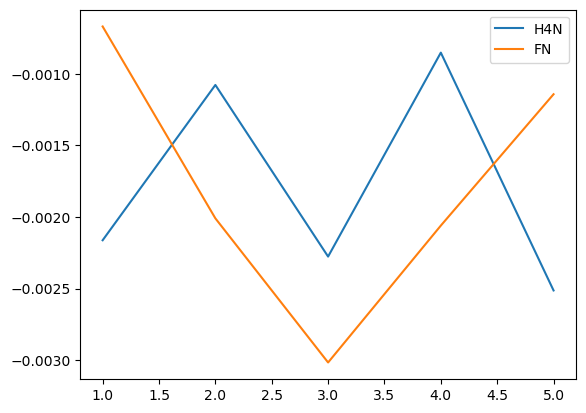

In [30]:
plt.plot(plot_df_h4n, label = 'H4N')
plt.plot(plot_df_fn, label = 'FN')
plt.legend()
plt.show()